<a href="https://colab.research.google.com/github/cmimholz/computational-language-technology-project/blob/main/notebooks/stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 2: Advanced Embedding Models Training and Analysis
This notebook explores advanced embedding models to analyze and compare the content of the Cleantech Media and Google Patent datasets. The goal is to develop meaningful vector representations of the text data using word embeddings, sentence embeddings, and transfer learning techniques.


## Data Preparation for Embeddings
At this stage, we need to ensure that our dataset is properly cleaned and preprocessed to generate high-quality embeddings.


In [ ]:
#Packages
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 gensim==4.3.3
!pip install datasets
!pip install unidecode

import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
import spacy
from spacy.lang.en import English
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
PUNCTUATIONS = string.punctuation
stemmer = PorterStemmer()
from collections import Counter

from unidecode import unidecode
import unidecode
import matplotlib.pyplot as plt
from pathlib import Path
# Default Style Settings
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200
#%matplotlib inline

from datasets import Dataset

from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import RobertaModel

import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from gensim.models.doc2vec import Doc2Vec, TaggedDocument # Import TaggedDocument
from gensim.models import Word2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstall

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -r /content/drive/MyDrive/computational-language-technology-project/notebooks/requirements.txt

In [ ]:
#load the pre-cleaned dataset from stage 1
media_preprocessed_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_pre-cleaned.csv"
patent_preprocessed_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/google_patent_pre-cleaned.csv"

df_media_read = pd.read_csv(media_preprocessed_path, header = 0)
df_patent_read = pd.read_csv(patent_preprocessed_path, header = 0)
df_media_processed = df_media_read.copy()
df_patent_processed = df_patent_read.copy()

First, all function for the preprocessing steps are loaded:

In [ ]:
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text) if isinstance(text, str) else text

def remove_dates(text):
    text = re.sub(r'\d{1,2}(st|nd|rd|th)?[-./]\d{1,2}[-./]\d{2,4}', '', text)
    pattern = re.compile(r'(\d{1,2})?(st|nd|rd|th)?[-./,]?\s?(of)?\s?([J|j]an(uary)?|[F|f]eb(ruary)?|[Mm]ar(ch)?|[Aa]pr(il)?|[Mm]ay|[Jj]un(e)?|[Jj]ul(y)?|[Aa]ug(ust)?|[Ss]ep(tember)?|[Oo]ct(ober)?|[Nn]ov(ember)?|[Dd]ec(ember)?)\s?(\d{1,2})?(st|nd|rd|th)?\s?[-./,]?\s?(\d{2,4})?')
    text = pattern.sub(r'', text)
    return text if isinstance(text, str) else text

def remove_html(text):
    clean_text = BeautifulSoup(text).get_text()
    return clean_text

def remove_tags_mentions(text):
    pattern = re.compile(r'(@\S+|#\S+)')
    return pattern.sub('', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))


def remove_whitespaces(text):
    return " ".join(text.split())


def accented_to_ascii(text):
    return unidecode.unidecode(text)


# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]

Now we apply the function to both datasets. Stopwords are retained in both the Media and Patent datasets to preserve the natural text structure and important contextual relationships. This ensures that technical expressions in patents and domain-specific phrasing in media remain intact.  

While keeping stopwords increases dataset size and computational cost, potentially introducing some noise in word embeddings, removing them could disrupt the meaning of technical terms in patents and reduce readability in media content, leading to a loss of critical context.  


In [ ]:
# lower casing
df_media_processed['content'] = df_media_processed['content'].apply(lambda x: x.lower())

# Call all removals
df_media_processed['content'] = df_media_processed['content'].map(remove_emails)
df_media_processed['content'] = df_media_processed['content'].map(remove_dates)
df_media_processed['content'] = df_media_processed['content'].map(remove_html)
df_media_processed['content'] = df_media_processed['content'].map(remove_tags_mentions)
df_media_processed['content'] = df_media_processed['content'].map(remove_punctuation)
df_media_processed['content'] = df_media_processed['content'].map(remove_whitespaces)
df_media_processed['content'] = df_media_processed['content'].map(accented_to_ascii)
df_media_processed['tokens'] = df_media_processed['content'].apply(tokenize)

df_media_processed.head()

id  \
0  93320   
1  93321   
2  98159   
3  98158   
4  31128   

                                                                                           title  \
0                                                      XPeng Delivered ~100,000 Vehicles In 2021   
1                                                  Green Hydrogen: Drop In Bucket Or Big Splash?   
2            World’ s largest floating PV plant goes online in China – pv magazine International   
3  Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International   
4                        Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’   

         date  \
0  2022-01-02   
1  2022-01-02   
2  2022-01-03   
3  2022-01-03   
4  2022-01-03   

                                                                                                                                                                                                   content  \
0  chinese automotive startup xpeng has shown one of the most dramatic auto production rampups in history and the good news is it only produces 100 st electric vehicles evs at a mere 7 years of age a...   
1  sinopec has laid plans to build the largest green hydrogen production facility in the world but interest in fossilsourced hydrogen continues apace skepticism abounds over the green hydrogen field ...   
2  huaneng power international has switched on a 320 mw floating pv array in china' s shandong province it deployed the plant in two phases on a reservoir near its 265 gw dezhou thermal power station...   
3  according to the iranian authorities there are currently more than 80gw of renewable energy projects that were submitted by private investors for review iran had around 414mw of installed solar po...   
4  daily gpi infrastructure ngi all news access electric transmission planners with the eastern interconnection a major power grid serving twothirds of the united states and canada recently gave a fa...   

            domain  \
0    cleantechnica   
1    cleantechnica   
2      pv-magazine   
3      pv-magazine   
4  naturalgasintel   

                                                                                                                  url  \
0                                       https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/   
1      https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-make-a-splash/   
2                       https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/   
3  https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-four-years/#comments   
4               https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-ways/   

                                                                                                                                                                                                    tokens  
0  [chinese, automotive, startup, xpeng, has, shown, one, of, the, most, dramatic, auto, production, rampups, in, history, and, the, good, news, is, it, only, produces, 100, st, electric, vehicles, e...  
1  [sinopec, has, laid, plans, to, build, the, largest, green, hydrogen, production, facility, in, the, world, but, interest, in, fossilsourced, hydrogen, continues, apace, skepticism, abounds, over,...  
2  [huaneng, power, international, has, switched, on, a, 320, mw, floating, pv, array, in, china, ', s, shandong, province, it, deployed, the, plant, in, two, phases, on, a, reservoir, near, its, 265...  
3  [according, to, the, iranian, authorities, there, are, currently, more, than, 80gw, of, renewable, energy, projects, that, were, submitted, by, private, investors, for, review, iran, had, around, ...  
4  [daily, gpi, infrastructure, ngi, all, news, access, electric, transmission, planners, with, the, easter

In [ ]:
# lower casing
df_patent_processed['abstract'] = df_patent_processed['abstract'].apply(lambda x: x.lower())

# Call all removals
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_emails)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_dates)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_html)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_tags_mentions)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_punctuation)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_whitespaces)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(accented_to_ascii)
df_patent_processed['tokens'] = df_patent_processed['abstract'].apply(tokenize)

df_patent_processed.head()

publication_number application_number country_code  \
0     CN-117151396-A  CN-202311109834-A           CN   
1     CN-117147382-A  CN-202310985511-A           CN   
2     CN-113344288-B  CN-202110717505-A           CN   
3     CN-117153944-A  CN-202311209193-A           CN   
4     CN-116911695-B  CN-202311167289-A           CN   

                                                                                                             title  \
0  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-microgrid system   
1          Device for monitoring hydrogen atom crossing grain boundary diffusion by using SKPFM and testing method   
2   Cascade hydropower station group water level prediction method and device and computer readable storage medium   
3                                    Heterojunction solar cell, preparation method thereof and photovoltaic module   
4                                                          Flexible resource adequacy evaluation method and device   

                                                                                                                                                                                                  abstract  \
0  the invention discloses a distributed economic dispatching method of a wind solar and methane hydrogen multienergy multimicrogrid system firstly the wind solar and hydrogen multienergy multimicrog...   
1  the invention provides a device and a method for monitoring hydrogen atom crossing grain boundary diffusion by using skpfm and relates to the technical field of hydrogen energy utilization the dev...   
2  the invention discloses a cascade hydropower station group water level prediction method a cascade hydropower station group water level prediction device and a computer readable storage medium and...   
3  the application provides a heteroction solar cell a preparation method thereof and a photovoltaic module and relates to the technical field of photovoltaics the preparation method of the heterocti...   
4  the invention relates to a flexible resource adequacy evaluation method and device of an electric power system belongs to the technical field of electric power and solves the problems that a large...   

   publication_date                                         inventor  \
0          20231201                      ['HU PENGFEI', 'LI ZIMENG']   
1          20231201  ['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']   
2          20231201                                               []   
3          20231201                    ['TONG HONGBO', 'JIN YUPENG']   
4          20231201                                               []   

      cpc_code  is_english  \
0    G06Q50/06        True   
1    G01N13/00        True   
2    G06Q10/04        True   
3   H01L31/074        True   
4  H02J2203/20        True   

                                                                                                                                                                                                    tokens  
0  [the, invention, discloses, a, distributed, economic, dispatching, method, of, a, wind, solar, and, methane, hydrogen, multienergy, multimicrogrid, system, firstly, the, wind, solar, and, hydrogen...  
1  [the, invention, provides, a, device, and, a, method, for, monitoring, hydrogen, atom, crossing, grain, boundary, diffusion, by, using, skpfm, and, relates, to, the, technical, field, of, hydrogen...  
2  [the, invention, discloses, a, cascade, hydropower, station, group, water, level, prediction, method, a, cascade, hydropower, station, group, water, level, prediction, device, and, a, computer, re...  
3  [the, application, provides, a, heteroction, solar, cell, a, preparation, method, thereof, and, a, photovoltaic, module, and, relates, to, the, technical, field, of, photovoltaics, the, preparatio...  
4  [the, invention, relates, to, a, flexible, resource, adequacy, evaluation, me

In [ ]:
df_media = df_media_processed.copy()
df_patent= df_patent_processed.copy()

For the RoBERTa Fine-Tuning (Transformer-Based Model) & Doc2Vec we have other data preprocessing requirements. In RoBERTa for example the goal is to undestand contextual meaning of words using deep contexutal embedding. As RoBERTa uses punctuation to understand sentence meaning (e.g., questions, negation, and lists) we need an other dataset which preservs those. We will use the same dataset also for Doc2Vec.

**Doc2Vec:**
- Stopwords: Stopwords are crucial for sentence meaning (e.g., "not good" ≠ "good").
- Punctuation: Keep punctuation if it impacts meaning (e.g., "Let's eat, grandma" ≠ "Let's eat grandma").

**RoBERTa:**
- Stopword Removal: RoBERTa relies on full sentence structure, including stopwords. Removing them hurts performance.
- Punctuation: RoBERTa uses punctuation to understand sentence meaning (e.g., questions, negation, and lists).


In [ ]:
df_media_tl = df_media_read.copy()
df_patent_tl = df_patent_read.copy()

In [ ]:
# lower casing
df_media_tl['content'] = df_media_tl['content'].apply(lambda x: x.lower())

# Call all removals
df_media_tl['content'] = df_media_tl['content'].map(remove_emails)
df_media_tl['content'] = df_media_tl['content'].map(remove_dates)
df_media_tl['content'] = df_media_tl['content'].map(remove_html)
df_media_tl['content'] = df_media_tl['content'].map(remove_tags_mentions)
df_media_tl['content'] = df_media_tl['content'].map(remove_whitespaces)
df_media_tl['content'] = df_media_tl['content'].map(accented_to_ascii)
df_media_tl['tokens'] = df_media_tl['content'].apply(tokenize)


df_media_tl.head()

id  \
0  93320   
1  93321   
2  98159   
3  98158   
4  31128   

                                                                                           title  \
0                                                      XPeng Delivered ~100,000 Vehicles In 2021   
1                                                  Green Hydrogen: Drop In Bucket Or Big Splash?   
2            World’ s largest floating PV plant goes online in China – pv magazine International   
3  Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International   
4                        Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’   

         date  \
0  2022-01-02   
1  2022-01-02   
2  2022-01-03   
3  2022-01-03   
4  2022-01-03   

                                                                                                                                                                                                   content  \
0  ['chinese automotive startup xpeng has shown one of the most dramatic auto production ramp-ups in history, and the good news is it only produces 100% st electric vehicles ( evs). at a mere 7 years...   
1  ['sinopec has laid plans to build the largest green hydrogen production facility in the world, but interest in fossil-sourced hydrogen continues apace.', 'skepticism abounds over the green hydroge...   
2  ['huaneng power international has switched on a 320 mw floating pv array in china' s shandong province. it deployed the plant in two phases on a reservoir near its 2.65 gw dezhou thermal power sta...   
3  ['according to the iranian authorities, there are currently more than 80gw of renewable energy projects that were submitted by private investors for review.', 'iran had around 414mw of installed s...   
4  ['daily gpi', 'infrastructure | ngi all news access', 'electric transmission planners with the eastern interconnection, a major power grid serving two-thirds of the united states and canada, recen...   

            domain  \
0    cleantechnica   
1    cleantechnica   
2      pv-magazine   
3      pv-magazine   
4  naturalgasintel   

                                                                                                                  url  \
0                                       https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/   
1      https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-make-a-splash/   
2                       https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/   
3  https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-four-years/#comments   
4               https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-ways/   

                                                                                                                                                                                                    tokens  
0  [[, ', chinese, automotive, startup, xpeng, has, shown, one, of, the, most, dramatic, auto, production, ramp, -, ups, in, history, ,, and, the, good, news, is, it, only, produces, 100, %, st, elec...  
1  [[, ', sinopec, has, laid, plans, to, build, the, largest, green, hydrogen, production, facility, in, the, world, ,, but, interest, in, fossil, -, sourced, hydrogen, continues, apace, ., ', ,, ', ...  
2  [[, ', huaneng, power, international, has, switched, on, a, 320, mw, floating, pv, array, in, china, ', s, shandong, province, ., it, deployed, the, plant, in, two, phases, on, a, reservoir, near,...  
3  [[, ', according, to, the, iranian, authorities, ,, there, are, currently, more, than, 80gw, of, renewable, energy, projects, that, were, submitted, by, private, investors, for, review, ., ', ,, '...  
4  [[, ', daily, gpi, ', ,, ', infrastructure, |, ngi, all, news, access, ', ,, ', electric, transmission, 

In [ ]:
# lower casing
df_patent_tl['abstract'] = df_patent_tl['abstract'].apply(lambda x: x.lower())

# Call all removals
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_emails)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_dates)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_html)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_tags_mentions)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_whitespaces)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(accented_to_ascii)
df_patent_tl['tokens'] = df_patent_tl['abstract'].apply(tokenize)

df_patent_tl.head()

publication_number application_number country_code  \
0     CN-117151396-A  CN-202311109834-A           CN   
1     CN-117147382-A  CN-202310985511-A           CN   
2     CN-113344288-B  CN-202110717505-A           CN   
3     CN-117153944-A  CN-202311209193-A           CN   
4     CN-116911695-B  CN-202311167289-A           CN   

                                                                                                             title  \
0  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-microgrid system   
1          Device for monitoring hydrogen atom crossing grain boundary diffusion by using SKPFM and testing method   
2   Cascade hydropower station group water level prediction method and device and computer readable storage medium   
3                                    Heterojunction solar cell, preparation method thereof and photovoltaic module   
4                                                          Flexible resource adequacy evaluation method and device   

                                                                                                                                                                                                  abstract  \
0  the invention discloses a distributed economic dispatching method of a wind, solar and methane hydrogen multi-energy multi-microgrid system; firstly, the wind, solar and hydrogen multi-energy mult...   
1  the invention provides a device and a method for monitoring hydrogen atom crossing grain boundary diffusion by using skpfm, and relates to the technical field of hydrogen energy utilization. the d...   
2  the invention discloses a cascade hydropower station group water level prediction method, a cascade hydropower station group water level prediction device and a computer readable storage medium, a...   
3  the application provides a heteroction solar cell, a preparation method thereof and a photovoltaic module, and relates to the technical field of photovoltaics. the preparation method of the hetero...   
4  the invention relates to a flexible resource adequacy evaluation method and device of an electric power system, belongs to the technical field of electric power, and solves the problems that a lar...   

   publication_date                                         inventor  \
0          20231201                      ['HU PENGFEI', 'LI ZIMENG']   
1          20231201  ['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']   
2          20231201                                               []   
3          20231201                    ['TONG HONGBO', 'JIN YUPENG']   
4          20231201                                               []   

      cpc_code  is_english  \
0    G06Q50/06        True   
1    G01N13/00        True   
2    G06Q10/04        True   
3   H01L31/074        True   
4  H02J2203/20        True   

                                                                                                                                                                                                    tokens  
0  [the, invention, discloses, a, distributed, economic, dispatching, method, of, a, wind, ,, solar, and, methane, hydrogen, multi, -, energy, multi, -, microgrid, system, ;, firstly, ,, the, wind, ,...  
1  [the, invention, provides, a, device, and, a, method, for, monitoring, hydrogen, atom, crossing, grain, boundary, diffusion, by, using, skpfm, ,, and, relates, to, the, technical, field, of, hydro...  
2  [the, invention, discloses, a, cascade, hydropower, station, group, water, level, prediction, method, ,, a, cascade, hydropower, station, group, water, level, prediction, device, and, a, computer,...  
3  [the, application, provides, a, heteroction, solar, cell, ,, a, preparation, method, thereof, and, a, photovoltaic, module, ,, and, relates, to, the, technical, field, of, photovoltaics, ., the, p...  
4  [the, invention, relates, to, a, flexible, resource, adequacy, evaluation, me

In [ ]:
media_save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_cleaned_tl.csv"
df_media_tl.to_csv(media_save_path, index=False)
patent_save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/patent_dataset_cleaned_tl.csv"
df_patent_tl.to_csv(patent_save_path, index=False)

In [ ]:
#load the cleaned tl dataset
media_preprocessed_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_cleaned_tl.csv"
patent_preprocessed_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/patent_dataset_cleaned_tl.csv"

df_media_tl = pd.read_csv(media_preprocessed_path, header = 0)
df_patent_tl = pd.read_csv(patent_preprocessed_path, header = 0)

Now we are ready for the actual modelling.

The training and test splitting for the transfer learning is done later in this notebook!

## Word Embedding Training  

In this chapter we trained Word2Vec models on each dataset, starting with a baseline and later optimizing hyperparameters (vector size, window size, epochs). The embeddings were evaluated using word similarity, clustering, and visualization.  

Key considerations:  
- OOV Words: Word2Vec cannot handle unseen words.  
- Static Nature: Word order is respected, but embeddings do not adapt dynamically.  
- Language Constraint: Models were trained in English for consistency.  

The analysis helped identify semantic relationships, thematic overlaps, and domain-specific patterns across datasets.  



In [ ]:
word_counts_media = Counter(word for sentence in df_media['content'] for word in sentence.split())
total_tokens_media = sum(word_counts_media.values())
unique_tokens_media = len(word_counts_media)

word_counts_patent = Counter(word for sentence in df_patent['abstract'] for word in sentence.split())
total_tokens_patent = sum(word_counts_patent.values())
unique_tokens_patent = len(word_counts_patent)

print("Media:")
print(f"Total Words (Tokens): {total_tokens_media}")
print(f"Unique Words (Vocabulary Size): {unique_tokens_media}")

print("Patent:")
print(f"Total Words (Tokens): {total_tokens_patent}")
print(f"Unique Words (Vocabulary Size): {unique_tokens_patent}")

Media:
Total Words (Tokens): 14351671
Unique Words (Vocabulary Size): 191183
Patent:
Total Words (Tokens): 5310156
Unique Words (Vocabulary Size): 34717


### Baseline Model & Hyperparameter Adjustments  

Before adjusting model parameters, a baseline Word2Vec model will be trained using default settings. This baseline serves as a comparison point to assess performance improvements when adjusting hyperparameters based on dataset characteristics. Given the significant differences in dataset size and vocabulary diversity, we anticipate the need for the following optimizations:  

#### Media Dataset (Large-scale, High-Diversity)
- With 14.35M tokens and 191k unique words, this dataset has high lexical diversity and requires an efficient training approach.  
- CBOW (`sg=0`) is expected to perform well due to its efficiency in handling large datasets.  
- Window Size: To be adjusted to `7` to capture broader semantic relationships.  
- Feature Size (Vector Dimensionality):  `300` will be tested to best represent the large vocabulary.  
- Min Word Count: A threshold of `10` will help filter infrequent words while maintaining training efficiency.  

#### **Patent Dataset (Moderate-scale, Domain-Specific)**  
- With 5.31M tokens and a more compact vocabulary of 34.7k unique words, this dataset contains specialized terminology.  
- Skip-gram (`sg=1`) is expected to yield better results by enhancing rare technical term representations.  
- Window Size: To be adjusted to `7` to capture broader semantic relationships.
- Feature Size: A range of `200` will be evaluated, considering the domain-specific nature of the vocabulary.  
- Min Word Count: Expected to be lowered to `3` to retain rare but meaningful terms.  


In [ ]:
#Train Benchmark Model fro Media
# Set values for various parameters from example
feature_size = 100  # The dimensionality of the word vectors.
window_context = 5  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 5  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_media_standard = Word2Vec(sentences=df_media['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [ ]:
#Train Optimized  Model for Media
feature_size = 300
window_context = 7
min_word_count = 10
w2vmodel_media_optimized = Word2Vec(sentences=df_media['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

Now let's compare the similarity similar words in the different models (calculated by cosine similarity).

In [ ]:
w2vmodel_media_standard.wv.most_similar('energy', topn=5)

[('electricity', 0.683174192905426),
 ('power', 0.6232144832611084),
 ('energies', 0.5121316909790039),
 ('resource', 0.48293501138687134),
 ('energyket', 0.4737301468849182)]

In [ ]:
w2vmodel_media_optimized.wv.most_similar('energy', topn=5)

[('electricity', 0.5048590302467346),
 ('power', 0.5031506419181824),
 ('energies', 0.4441084563732147),
 ('energyket', 0.4289342164993286),
 ('resource', 0.3680981397628784)]

Key Insights

- The baseline model shows stronger associations with "electricity" and "power", reflecting conventional energy concepts.  
- The optimized model distributes similarity more evenly, introducing "intermittent", which may indicate improved context awareness.  
- Lower similarity scores in the optimized model suggest a broader semantic representation rather than overfitting to dominant terms.  

## Word Embedding Visualization Comparison  

To analyze the impact of hyperparameter tuning, we applied t-SNE to visualize word embeddings from both the baseline and optimized Word2Vec models. The same word sampling range (`index_to_key[200:350]`) and t-SNE settings (`n_components=2, perplexity=5, n_iter=5000, random_state=0`) were used to ensure comparability.

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


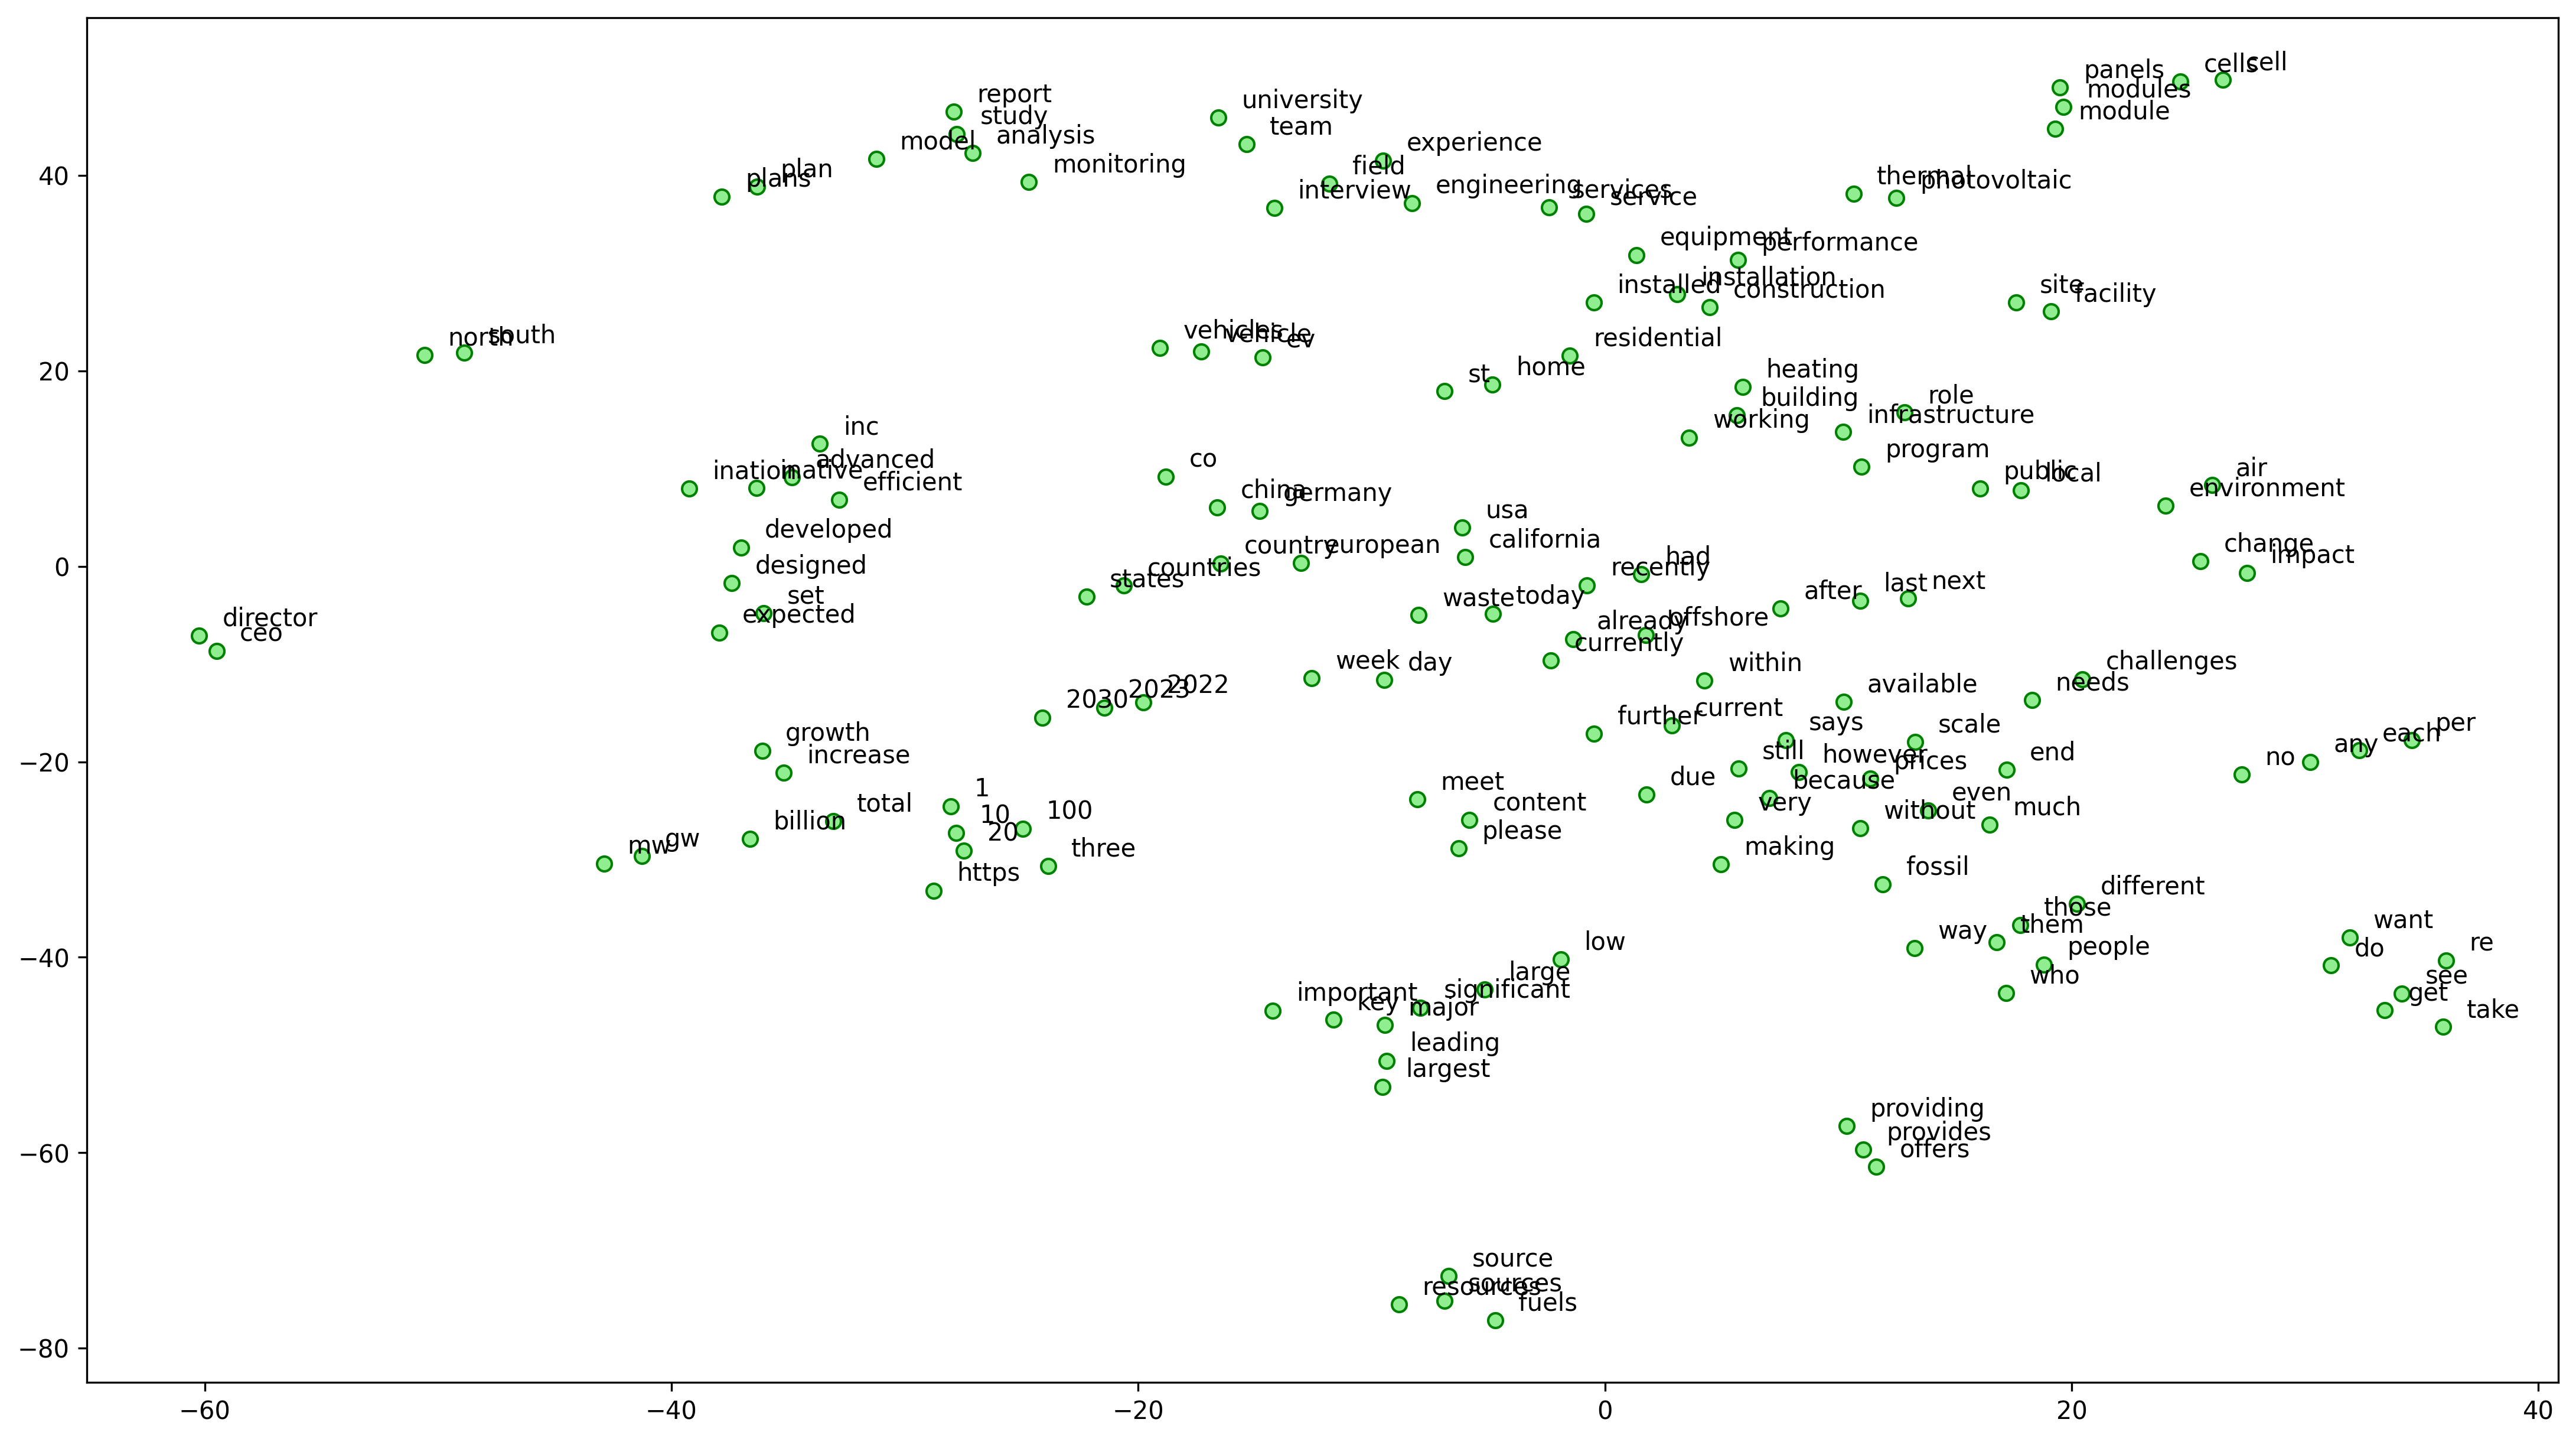

In [ ]:
words = w2vmodel_media_standard.wv.index_to_key[200:350]
wvs = w2vmodel_media_standard.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


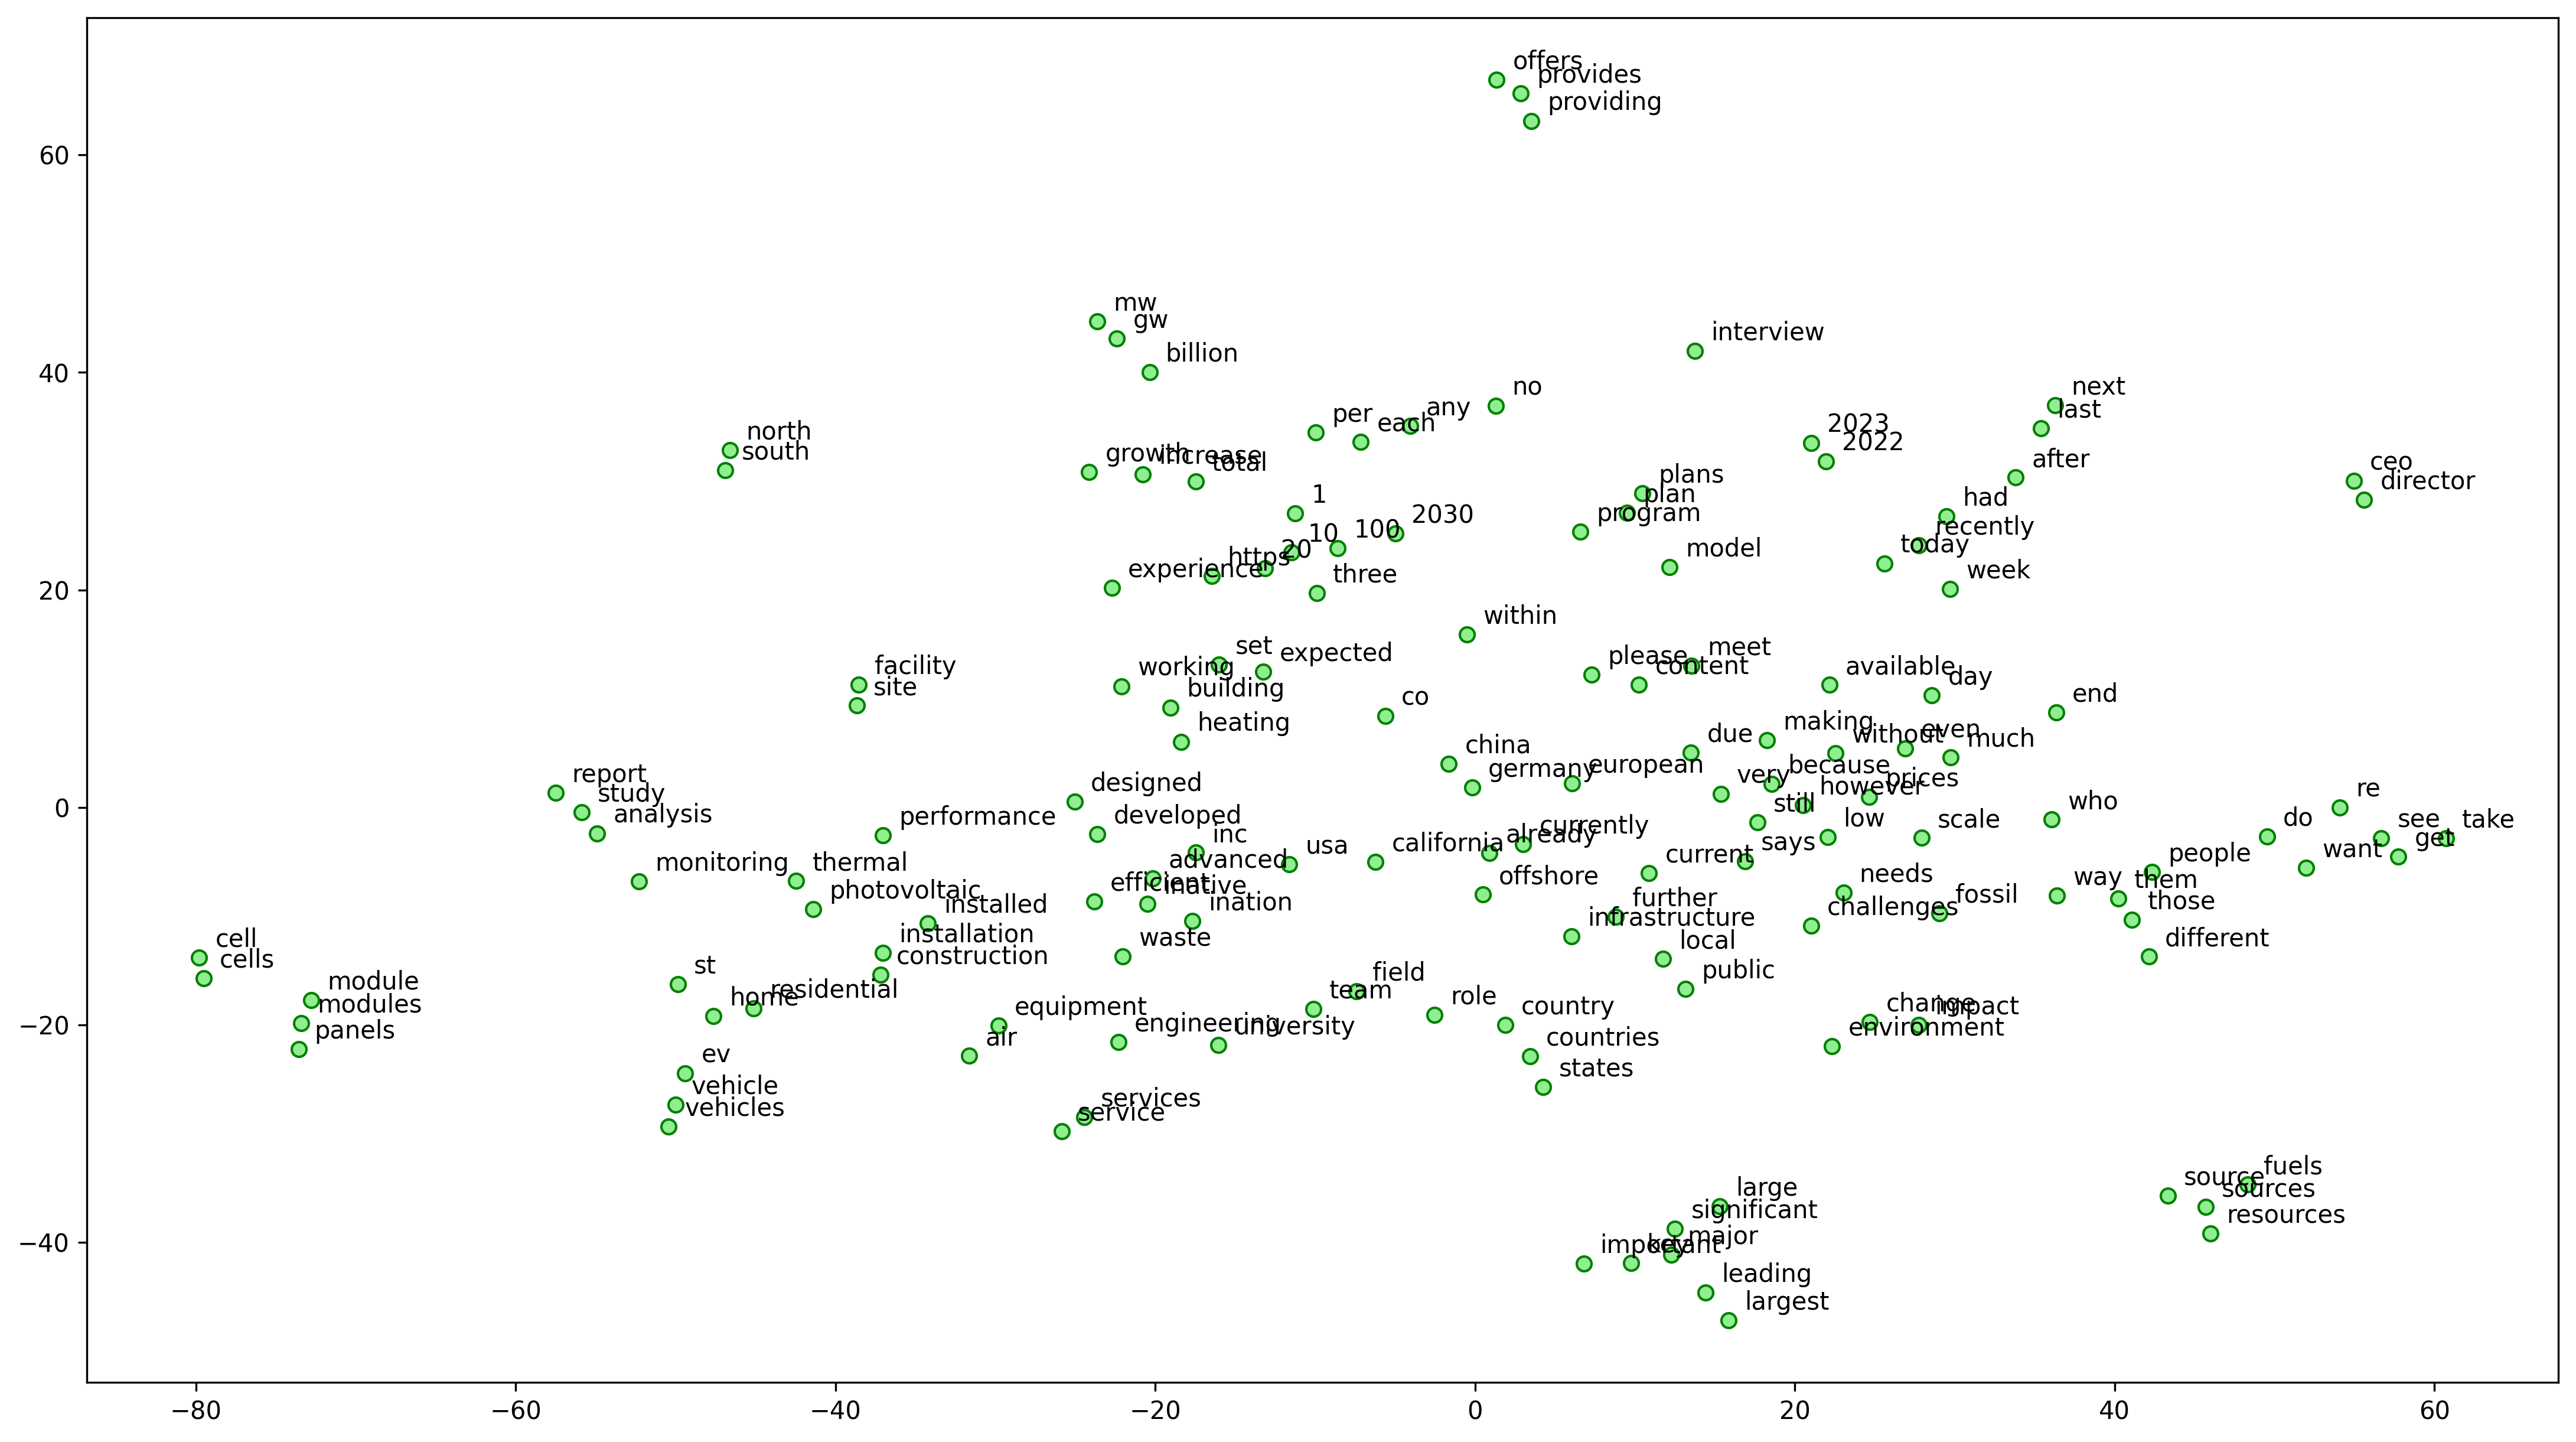

In [ ]:
words = w2vmodel_media_optimized.wv.index_to_key[200:350]
wvs = w2vmodel_media_optimized.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

**Key Observations**  
- The overall structure of both models is similar, indicating that core word relationships remain stable.  
- Some word placements differ, reflecting changes in how the models understand word similarity.  


**Conclusion**  
By keeping the sampling and visualization settings identical, we highlight the impact of hyperparameter tuning on word embeddings. The optimized model nor the standard provides a better visual performance,  additional testing is needed to quantify improvements beyond visualization.  

As we finished the media dataset let's now train two Word2Vec on the patent dataset

In [ ]:
#Train Benchmark Model for Patent
# Set values for various parameters from example
feature_size = 100
window_context = 5
min_word_count = 5

w2vmodel_patent_standard = Word2Vec(sentences=df_patent['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [ ]:
#Train Benchmark Model for Patent
# Set values for various parameters from example
feature_size = 200
window_context = 7
min_word_count = 3

w2vmodel_patent_optimized = Word2Vec(sentences=df_patent['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 1)

Now we do the same and compare the similarity similar words in the different models

In [ ]:
w2vmodel_patent_standard.wv.most_similar('energy', topn=5)

[('power', 0.6145719289779663),
 ('electricity', 0.5494726896286011),
 ('heat', 0.5201087594032288),
 ('heating', 0.4771978259086609),
 ('conversion', 0.45995739102363586)]

In [ ]:
w2vmodel_patent_optimized.wv.most_similar('energy', topn=5)

[('lowquality', 0.6879629492759705),
 ('storable', 0.6810980439186096),
 ('bicycles', 0.6699875593185425),
 ('peltier', 0.6666039824485779),
 ('energyelectric', 0.6631563305854797)]

**Key Insights**

- Patent Baseline Model: Similar words to "energy" include "power", "electricity", and "heat", reflecting conventional energy concepts.  
- Patent Optimized Model: Returns "lowquality", "storable", and "peltier", indicating a shift toward niche or less expected associations.  
- Comparison with Media Dataset:
  - The Media optimized model retains clearer energy-related terms.  
  - The Patent optimized model diverges more, suggesting stronger domain adaptation but potentially noisier relationships.  


The optimized Patent model produced unexpected similar words for "energy", likely due to the following factors:  

- Feature Size (`200`) May Be Too Small: A higher dimensionality (300-400) could better capture technical term relationships.  
- Skip-gram (`sg=1`) Overfitting to Rare Words: May prioritize low-frequency terms, leading to noisier associations.  
- Window Size (`7`) Too Large: Capturing broader context may have linked distant, less relevant terms. A smaller window (3-5) could improve focus.  
- Domain-Specific Language Variability: Patent terminology varies, and "energy" may appear in unexpected contexts (e.g., "peltier", "bicycles") due to specific technical applications.  



Nevertheless, next step is visualizing the two models as before.

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


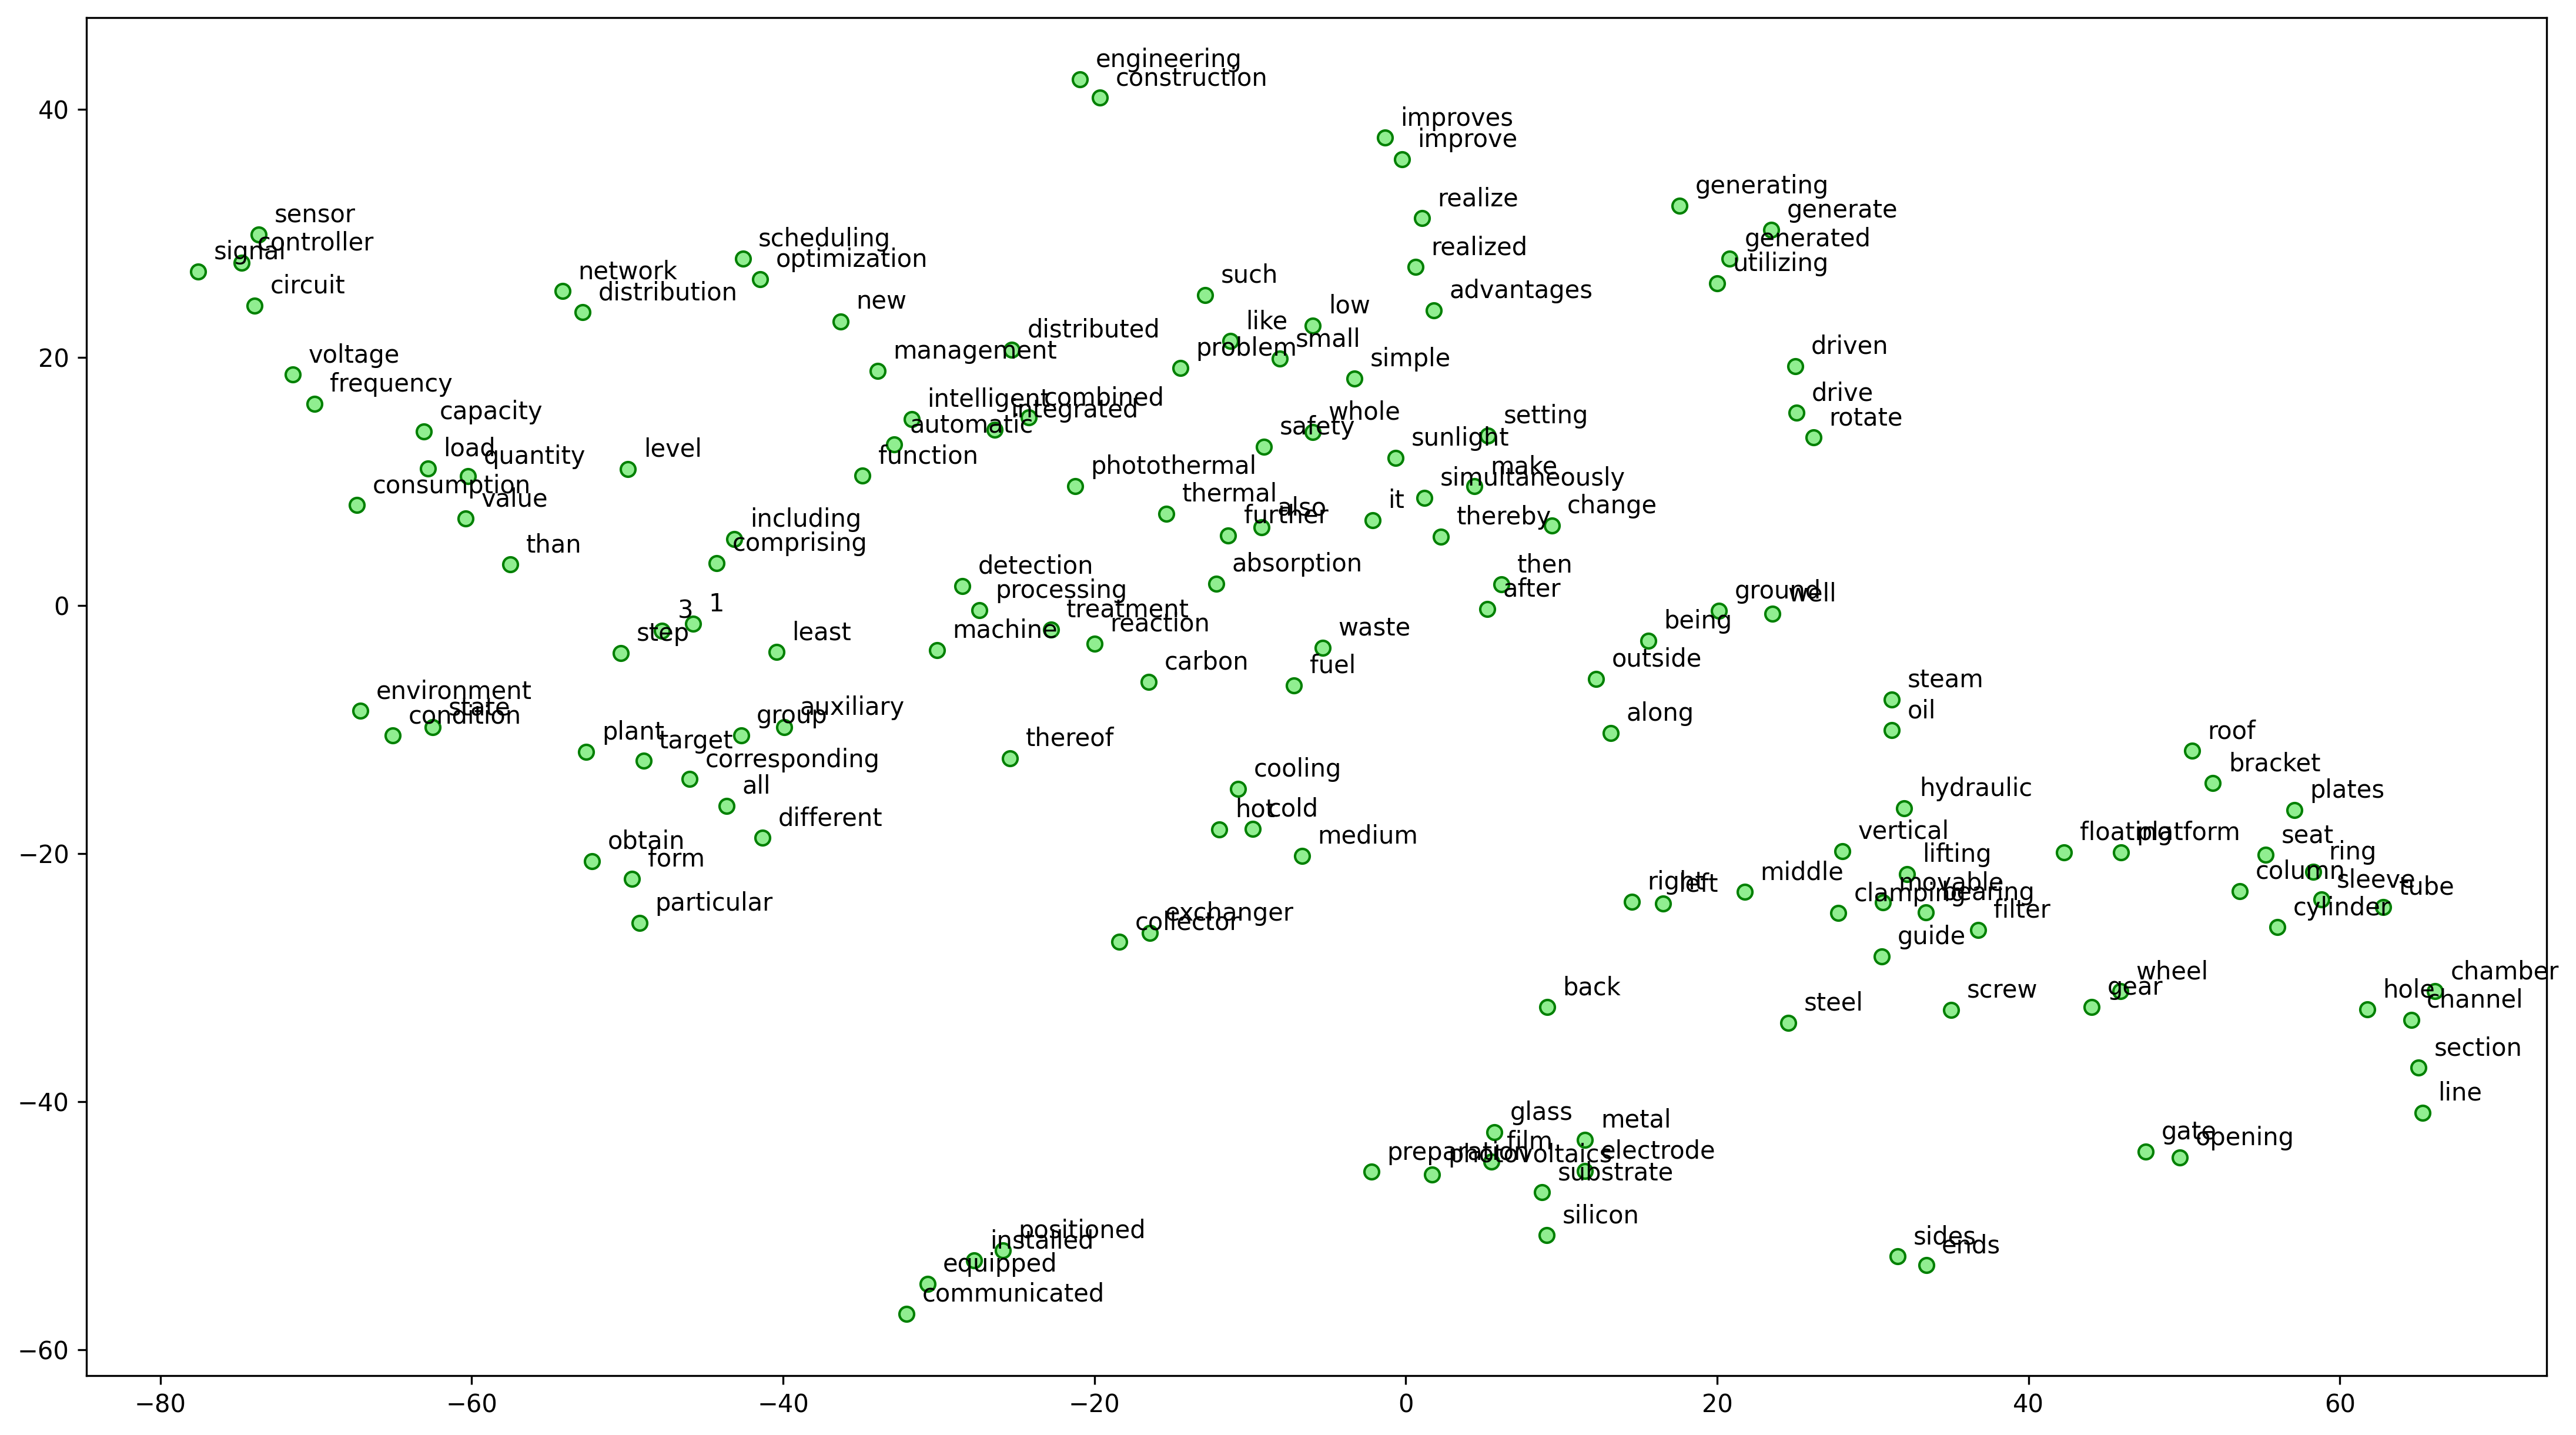

In [ ]:
from sklearn.manifold import TSNE

words = w2vmodel_patent_standard.wv.index_to_key[200:350]
wvs = w2vmodel_patent_standard.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


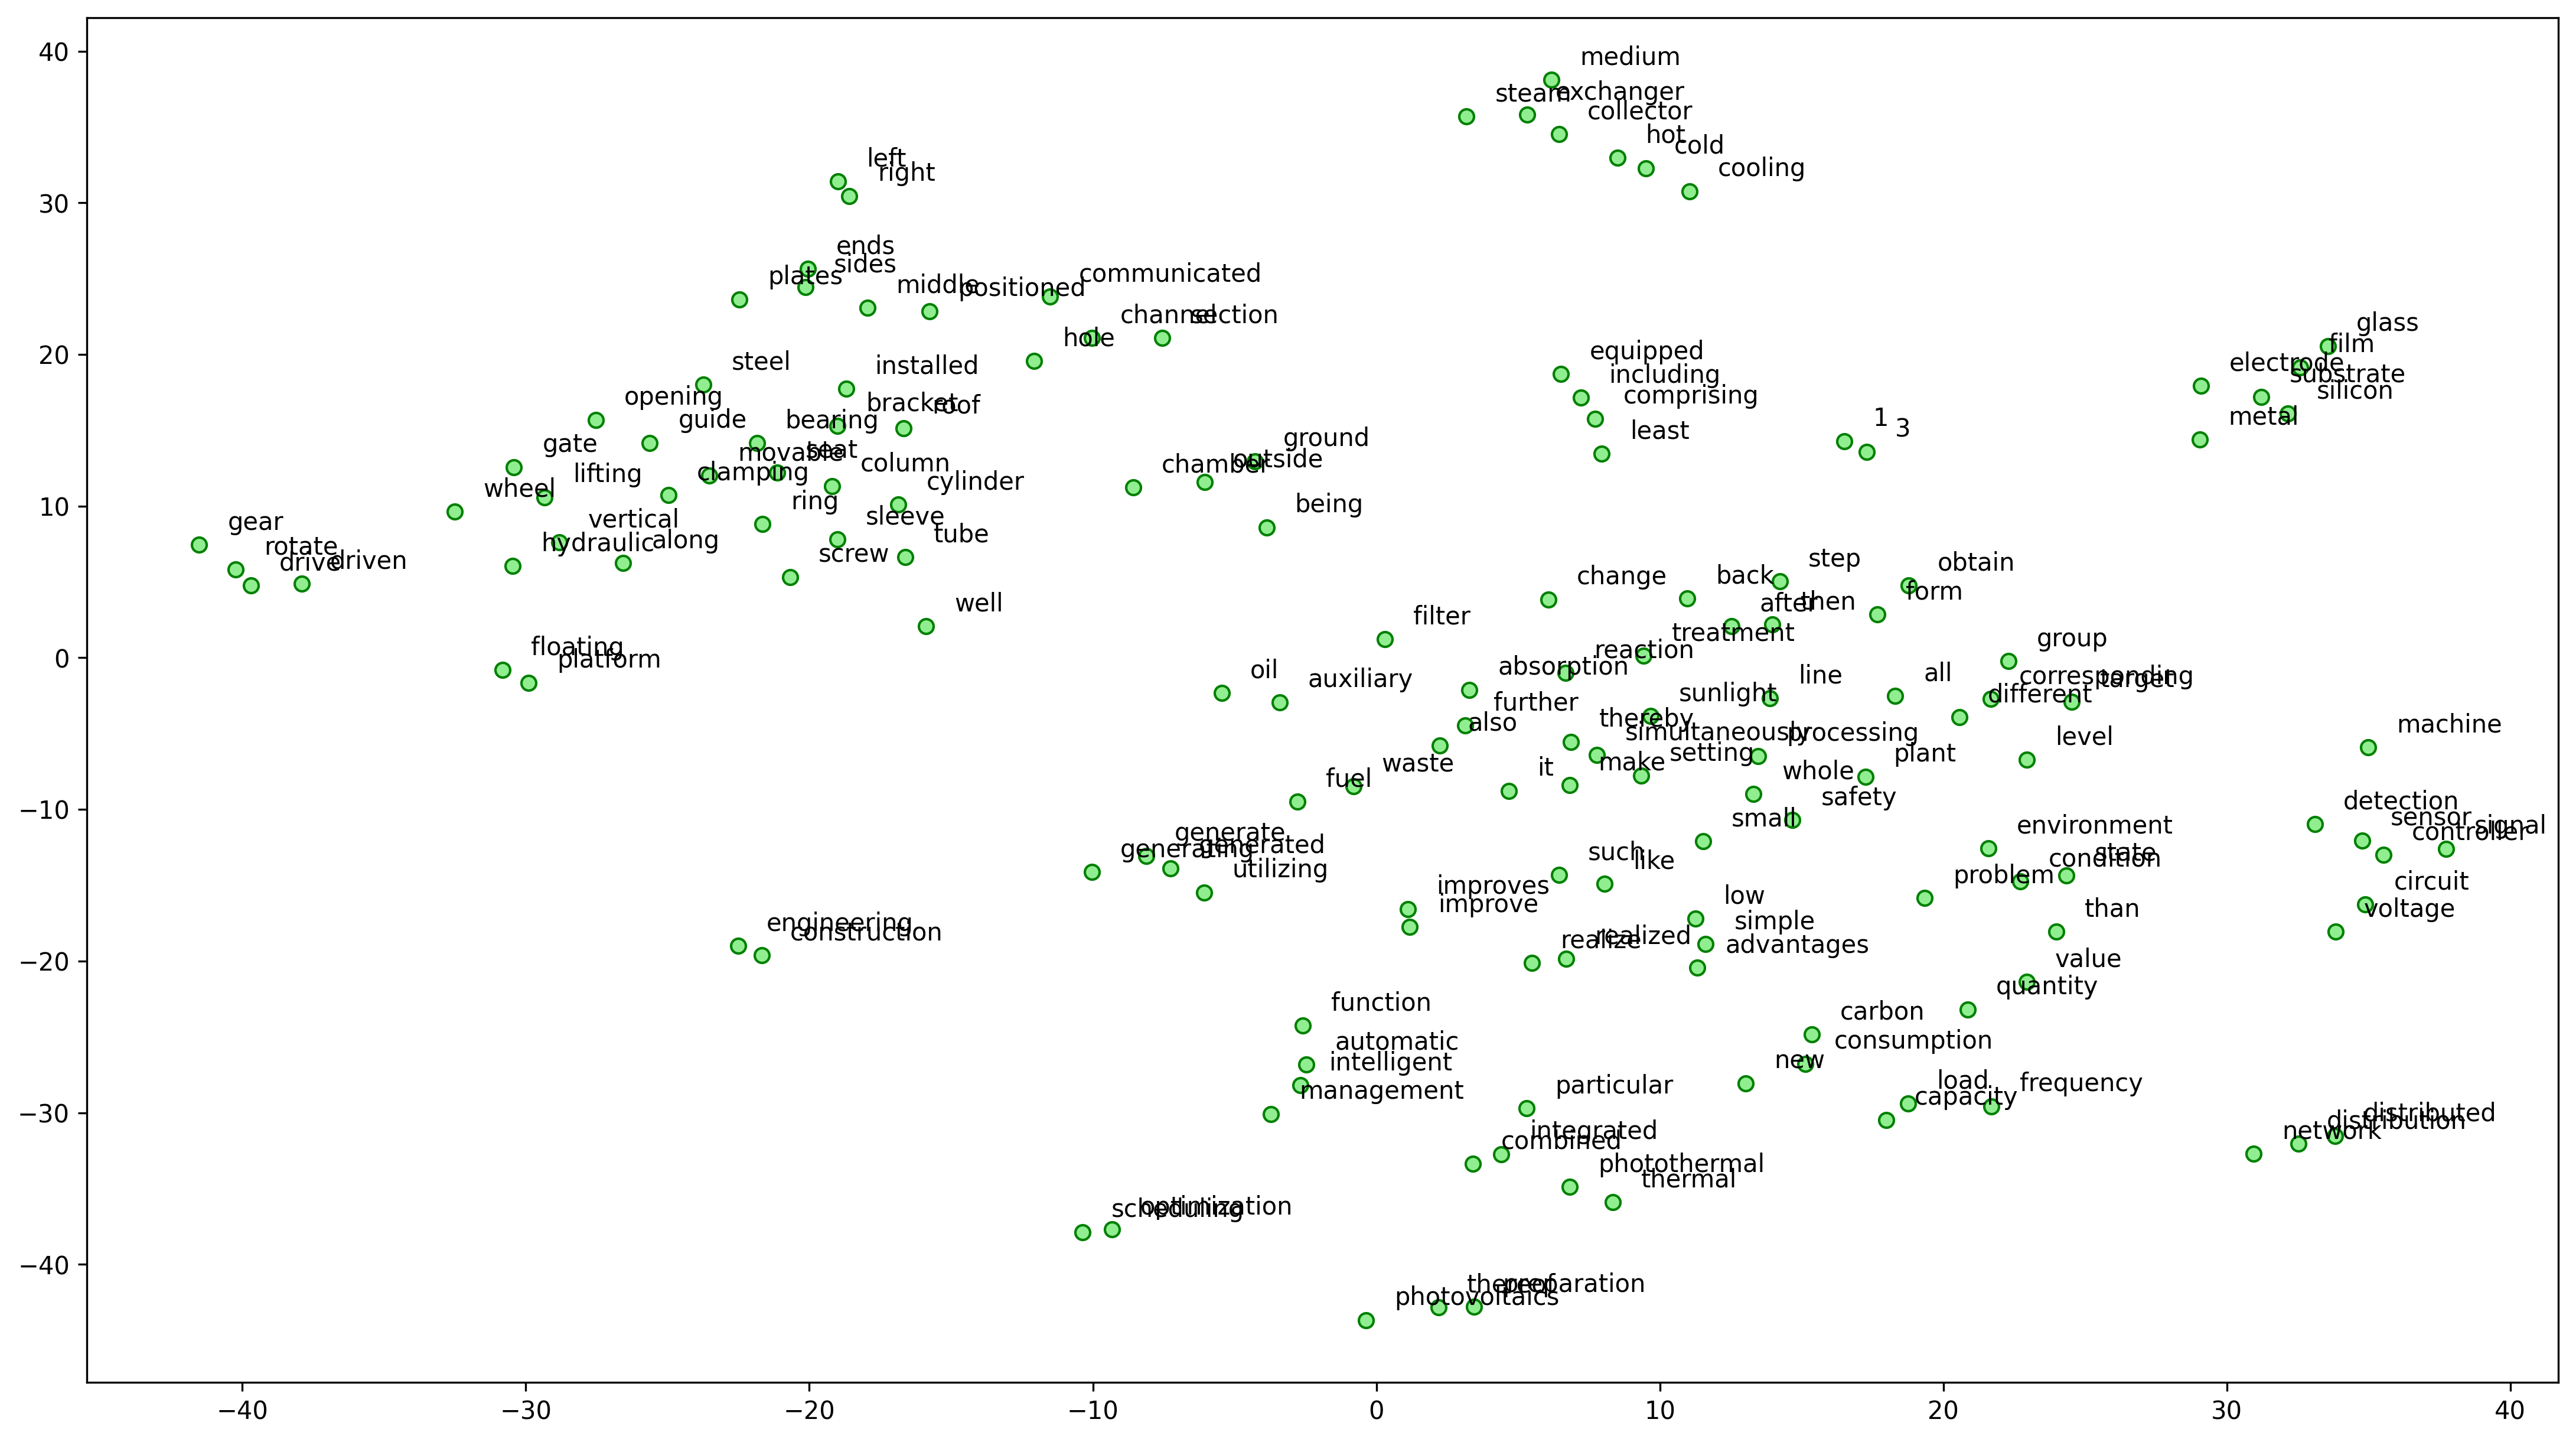

In [ ]:
from sklearn.manifold import TSNE

words = w2vmodel_patent_optimized.wv.index_to_key[200:350]
wvs = w2vmodel_patent_optimized.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

**Key Insights from Patent Dataset Visualization**
- Baseline Model:
  - Words appear more loosely scattered, with some structure but less distinct clusters.  

- Optimized Model:  
  - Clusters are more defined, indicating better semantic separation.  
  - Some unrelated words may still appear close, likely due to overfitting to rare terms (Skip-gram).  

## Sentence Embedding Training
Next we used is the Doc2Vec. It is an extension of Word2Vec that generates fixed-length vector representations for entire documents. It works by training a neural network to predict words using both word context and a unique document ID.

There are two main approaches:

- Distributed Memory (DM): Uses context words + document ID to predict target words.
- Distributed Bag of Words (DBOW): Uses only the document ID to predict random words from the document.

These learned document vectors capture the semantic meaning of texts and can be used for tasks like classification, clustering, and similarity search.


First, we again train a basline model and afterwords we train an optimized Doc2Vec

In [ ]:
# Function to tag documents (data is already tokenized)
def tag_documents(data, label_prefix):
    return [TaggedDocument(words=doc, tags=[f"{label_prefix}_{i}"]) for i, doc in enumerate(data)]

#Load datasets (Assuming 'df_media' and 'df_patent' contain tokenized text)
media_documents = tag_documents(df_media_tl['tokens'], "media")
patent_documents = tag_documents(df_patent_tl['tokens'], "patent")

#BASELINE MODEL (DEFAULT PARAMETERS) ###
def train_baseline_doc2vec(tagged_data, model_name):
    model = Doc2Vec(vector_size=100, window=5, min_count=5, workers=4, epochs=10, dm=1)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_name)
    return model

# Train baseline models
doc2vec_media_baseline = train_baseline_doc2vec(media_documents, "../models/doc2vec_media_baseline.model")
doc2vec_patent_baseline = train_baseline_doc2vec(patent_documents, "../models/doc2vec_patent_baseline.model")

#OPTIMIZED MODEL (TUNED HYPERPARAMETERS) ###
def train_optimized_doc2vec(tagged_data, model_name):
    model = Doc2Vec(vector_size=200, window=7, min_count=3, workers=4, epochs=20, dm=1, alpha=0.025)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_name)
    return model

# Train optimized models
doc2vec_media_optimized = train_optimized_doc2vec(media_documents, "../models/doc2vec_media_optimized.model")
doc2vec_patent_optimized = train_optimized_doc2vec(patent_documents, "../models/doc2vec_patent_optimized.model")


In [ ]:
doc2vec_media_baseline = Doc2Vec.load('/content/drive/MyDrive/computational-language-technology-project/models/doc2vec_media_baseline.model')
doc2vec_media_optimized = Doc2Vec.load('/content/drive/MyDrive/computational-language-technology-project/models/doc2vec_media_optimized.model')
doc2vec_patent_optimized = Doc2Vec.load('/content/drive/MyDrive/computational-language-technology-project/models/doc2vec_patent_optimized.model')
doc2vec_patent_baseline = Doc2Vec.load('/content/drive/MyDrive/computational-language-technology-project/models/doc2vec_patent_baseline.model')

In the next section we check how good the model performs.

In [ ]:
# Function to retrieve and print the closest 3 sentences
def most_similar_sentences(model, test_sentence, dataset, topn=3):
    vector = model.infer_vector(test_sentence)
    similar_docs = model.dv.most_similar([vector], topn=topn)

    print("\nClosest Sentences:")
    for doc_tag, similarity in similar_docs:
        doc_index = int(doc_tag.split("_")[1])

        print(f"Similarity: {similarity:.4f} → {doc_tag} → {' '.join(dataset.iloc[doc_index])}")

sample_sentence = ["energy", "efficiency", "renewable"]


print("\n Media Baseline Model")
most_similar_sentences(doc2vec_media_baseline, sample_sentence, df_media['tokens'])

print("\n Media Optimized Model")
most_similar_sentences(doc2vec_media_optimized, sample_sentence, df_media['tokens'])

print("\n Patent Baseline Model")
most_similar_sentences(doc2vec_patent_baseline, sample_sentence, df_patent['tokens'])

print("\n Patent Optimized Model")
most_similar_sentences(doc2vec_patent_optimized, sample_sentence, df_patent['tokens'])



 Media Baseline Model

Closest Sentences:
Similarity: 0.7625 → media_4340 → meyer burger has established a new partnership with a consortium of highprofile research institutions with the aim to produce solar cells with efficiencies of more than 30 on an industrial scale to get perovskite tandem technology with superhigh yields ready for mass production the swiss solar panel maker has signed multiyear cooperation agreements with csem from switzerland helmholtzzentrum berlin hzb the fraunhofer institute for solar energy systems ise in freiburg germany and the institute of photovoltaics at the university of stuttgart
Similarity: 0.7615 → media_10106 → the inuration of joe biden as president of the united states sparked auspicious investment into revitalizing renewable energy industries and helping make americans ' lives more sustainable that begins with the inflation reduction act and clean energy this blog will briefly talk about the inflation reduction act its passage why it is of such

**Key Findings**  


Media Dataset  
- Optimization significantly improved similarity (~0.76 baseline → ~0.79 optimized).
- Closest matches highlight renewable energy, sustainability, and clean technology.

Patent Dataset
- Moderate similarity (~0.62 baseline → ~0.63 optimized), minimal improvement after optimization.

- Closest matches focus on energy efficiency systems, renewable energy integration, and advanced analytical methods.


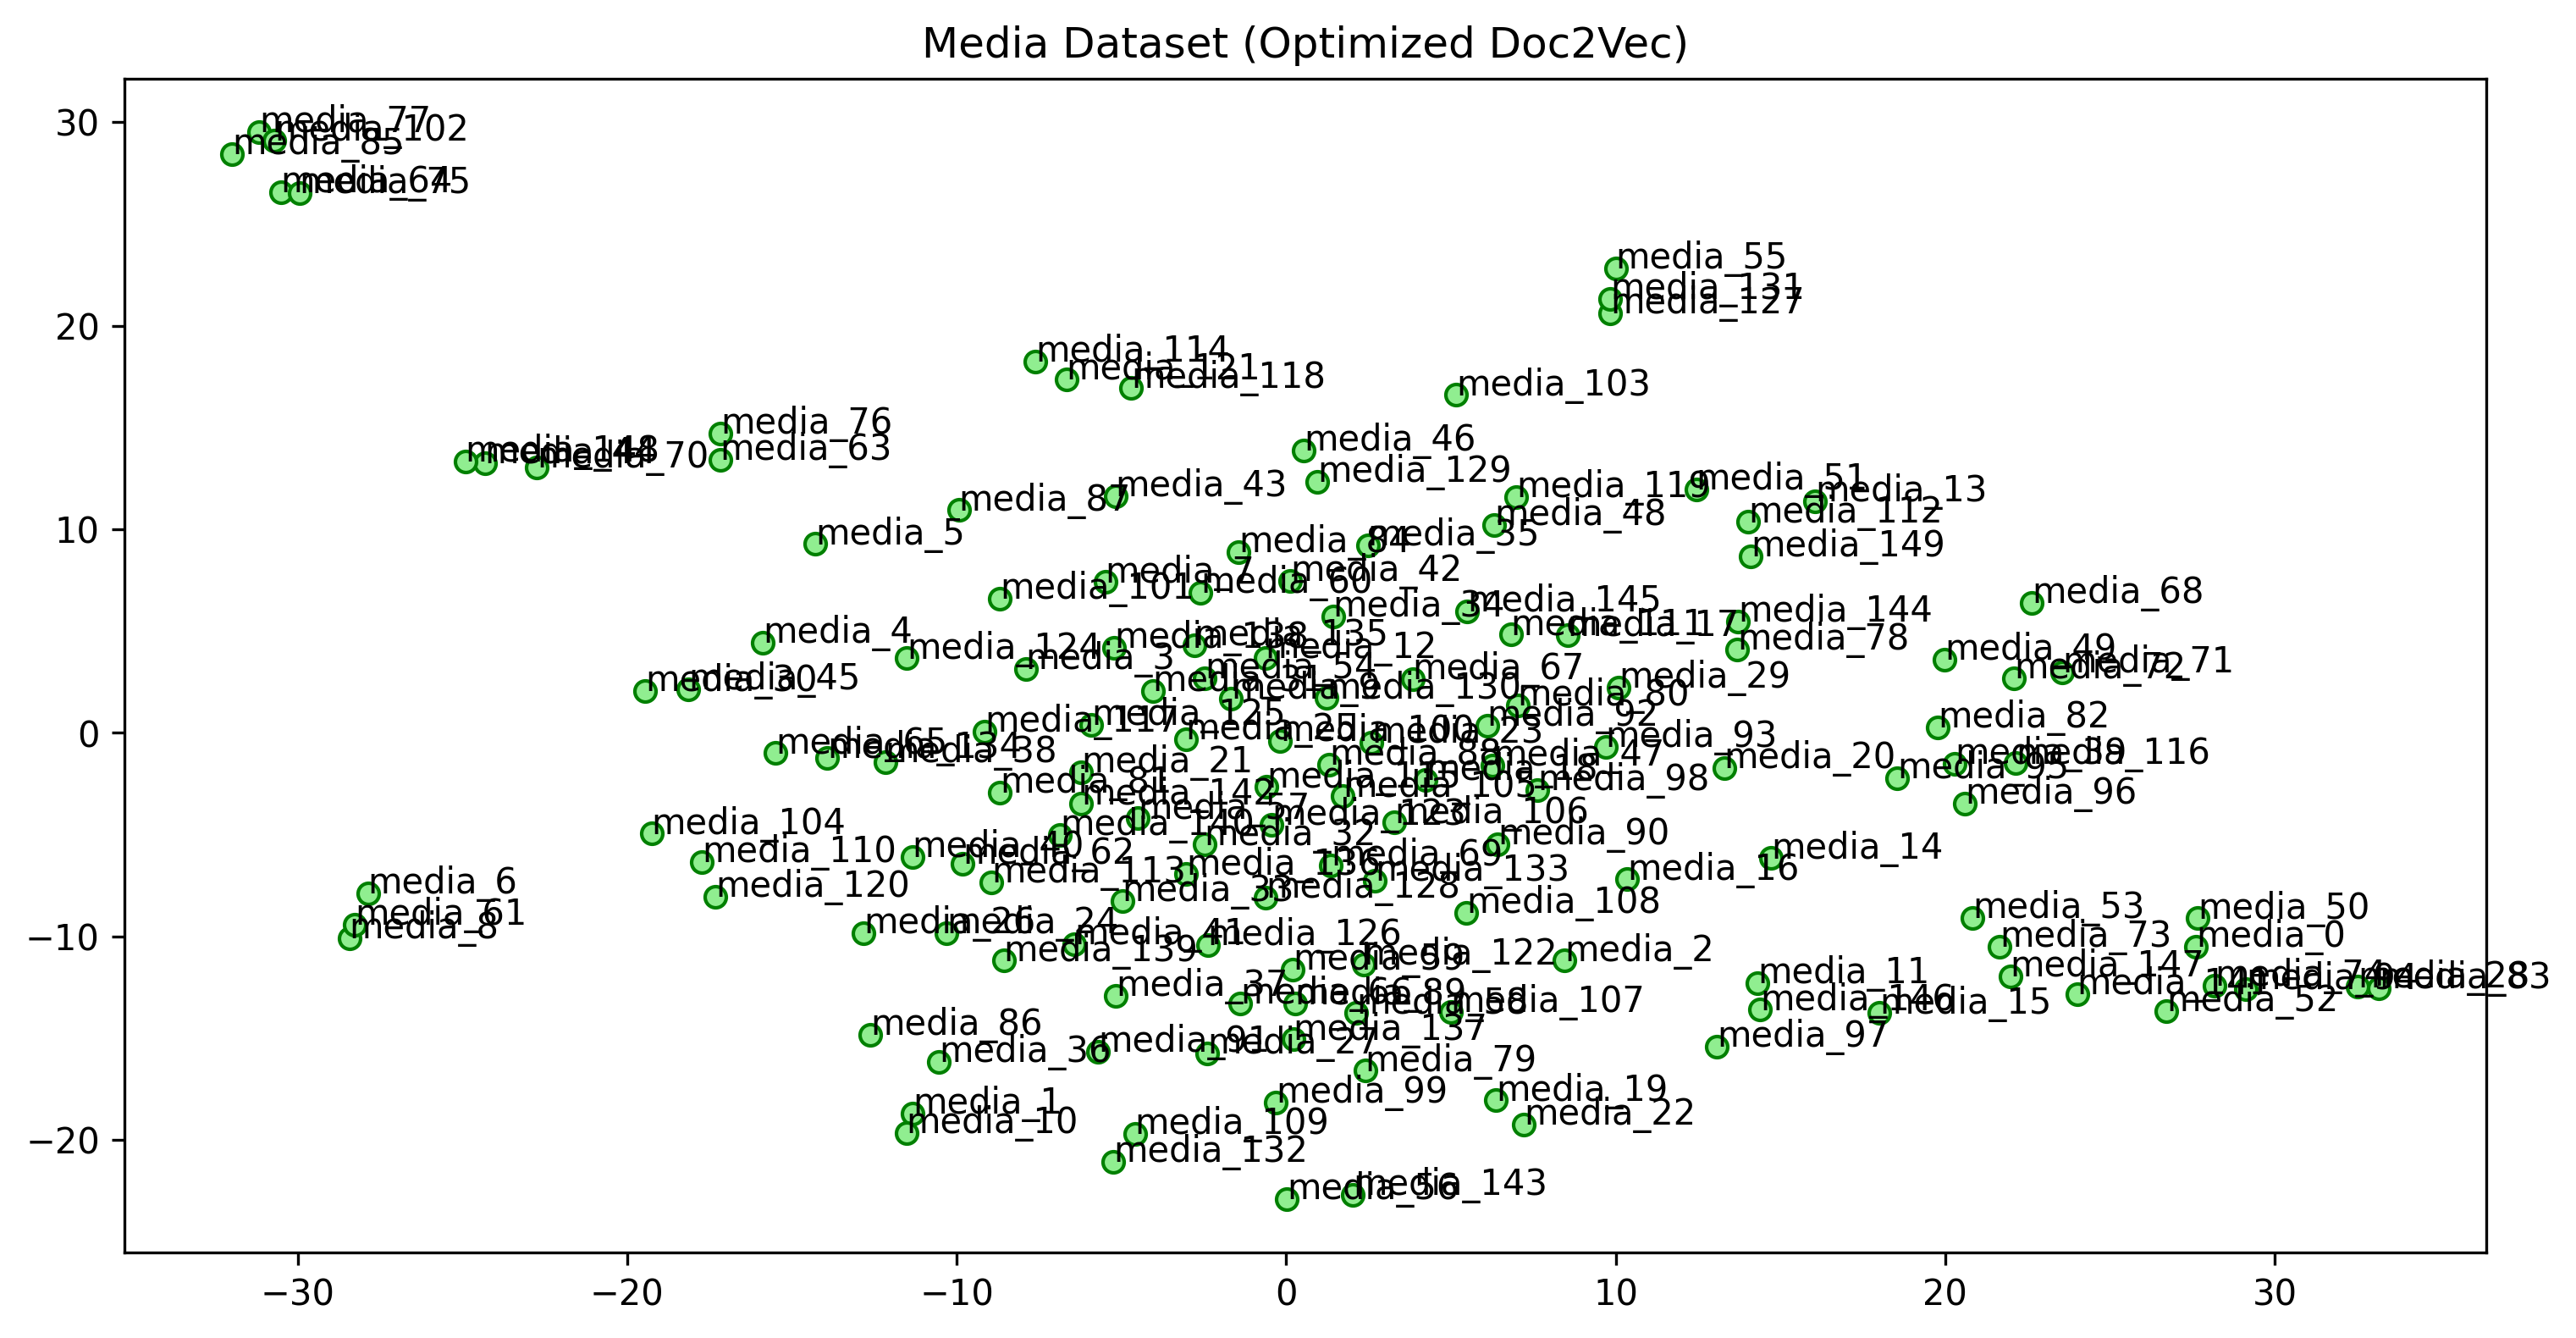

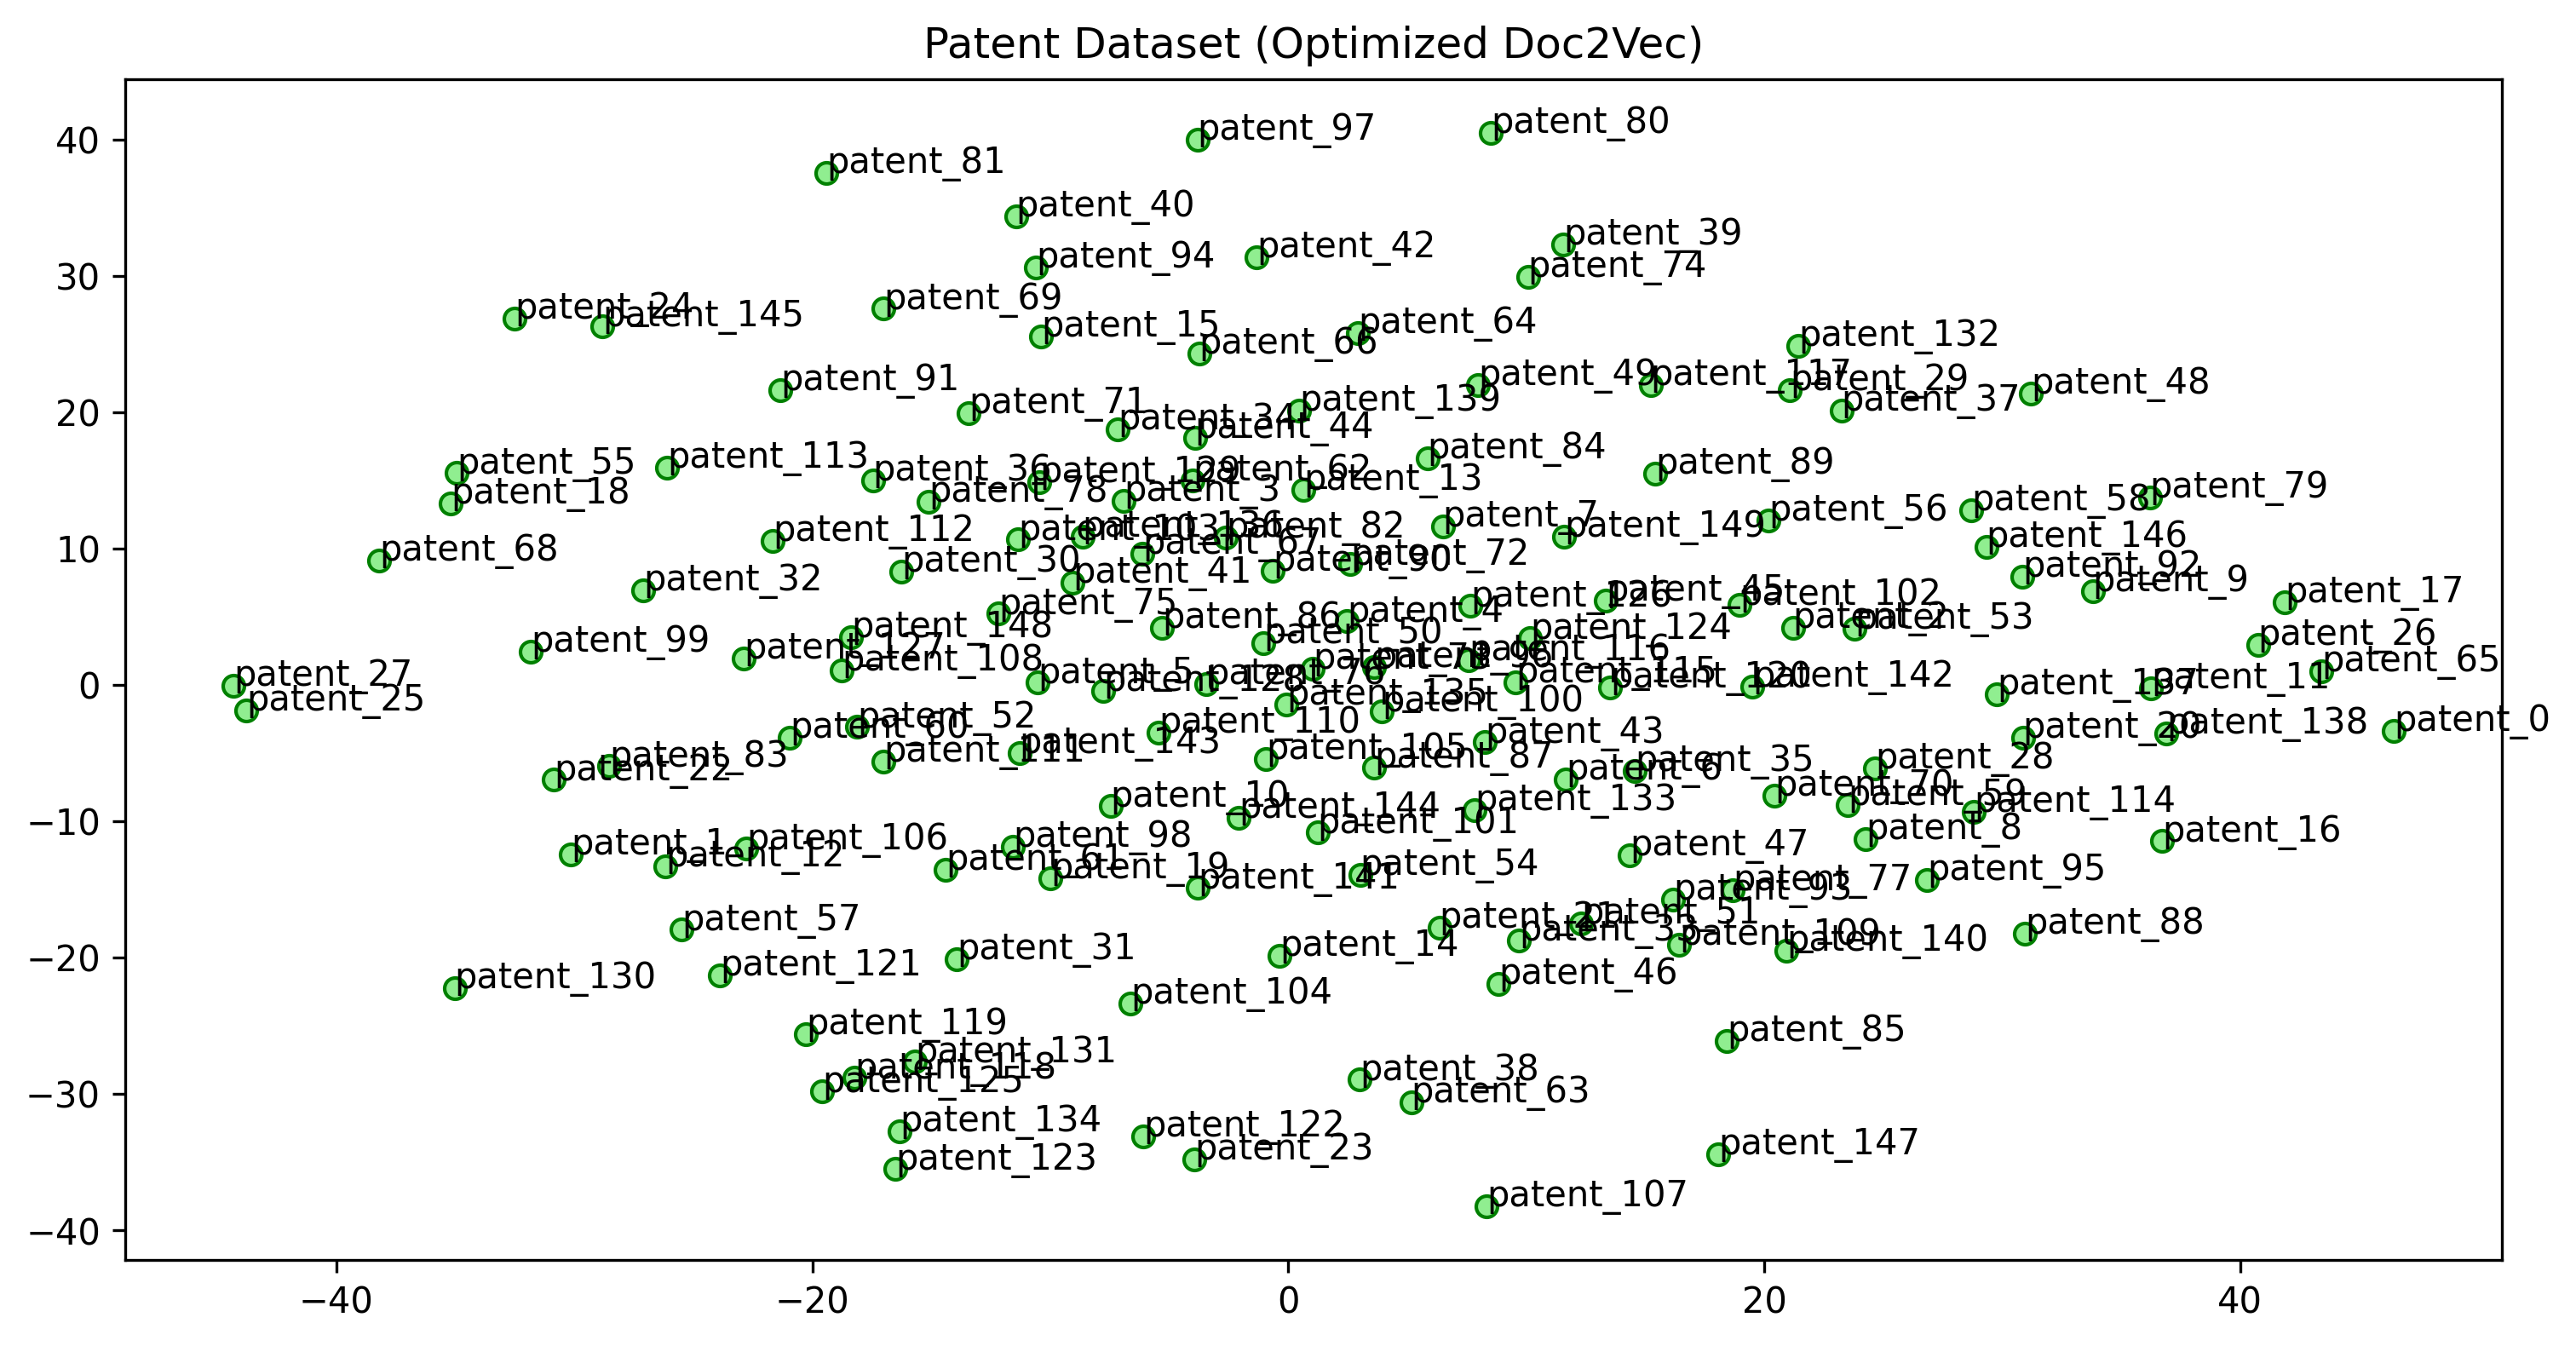

In [ ]:
### VISUALIZATION: CLUSTERING EMBEDDINGS WITH T-SNE ###

def visualize_embeddings(model, title):
    words = model.dv.index_to_key[:150]  # Get top 150 documents
    vectors = np.array([model.dv[word] for word in words])

    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    transformed_vectors = tsne.fit_transform(vectors)

    plt.figure(figsize=(12, 6))
    plt.scatter(transformed_vectors[:, 0], transformed_vectors[:, 1], c='lightgreen', edgecolors='g')
    for label, x, y in zip(words, transformed_vectors[:, 0], transformed_vectors[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
    plt.title(title)
    plt.show()

# Visualizing embeddings
visualize_embeddings(doc2vec_media_optimized, "Media Dataset (Optimized Doc2Vec)")
visualize_embeddings(doc2vec_patent_optimized, "Patent Dataset (Optimized Doc2Vec)")



**Key Findings from Visual Comparison of Media Models**
- Baseline Model: Forms compact and fragmented clusters, likely overfitting to frequent terms rather than generalizing semantic meaning.  
- Optimized Model: Produces fewer, more smoothly distributed clusters, capturing broader relationships between documents.  
- Comparison: The baseline model may be better for strict topic separation, while the optimized model generalizes document meanings more effectively.  


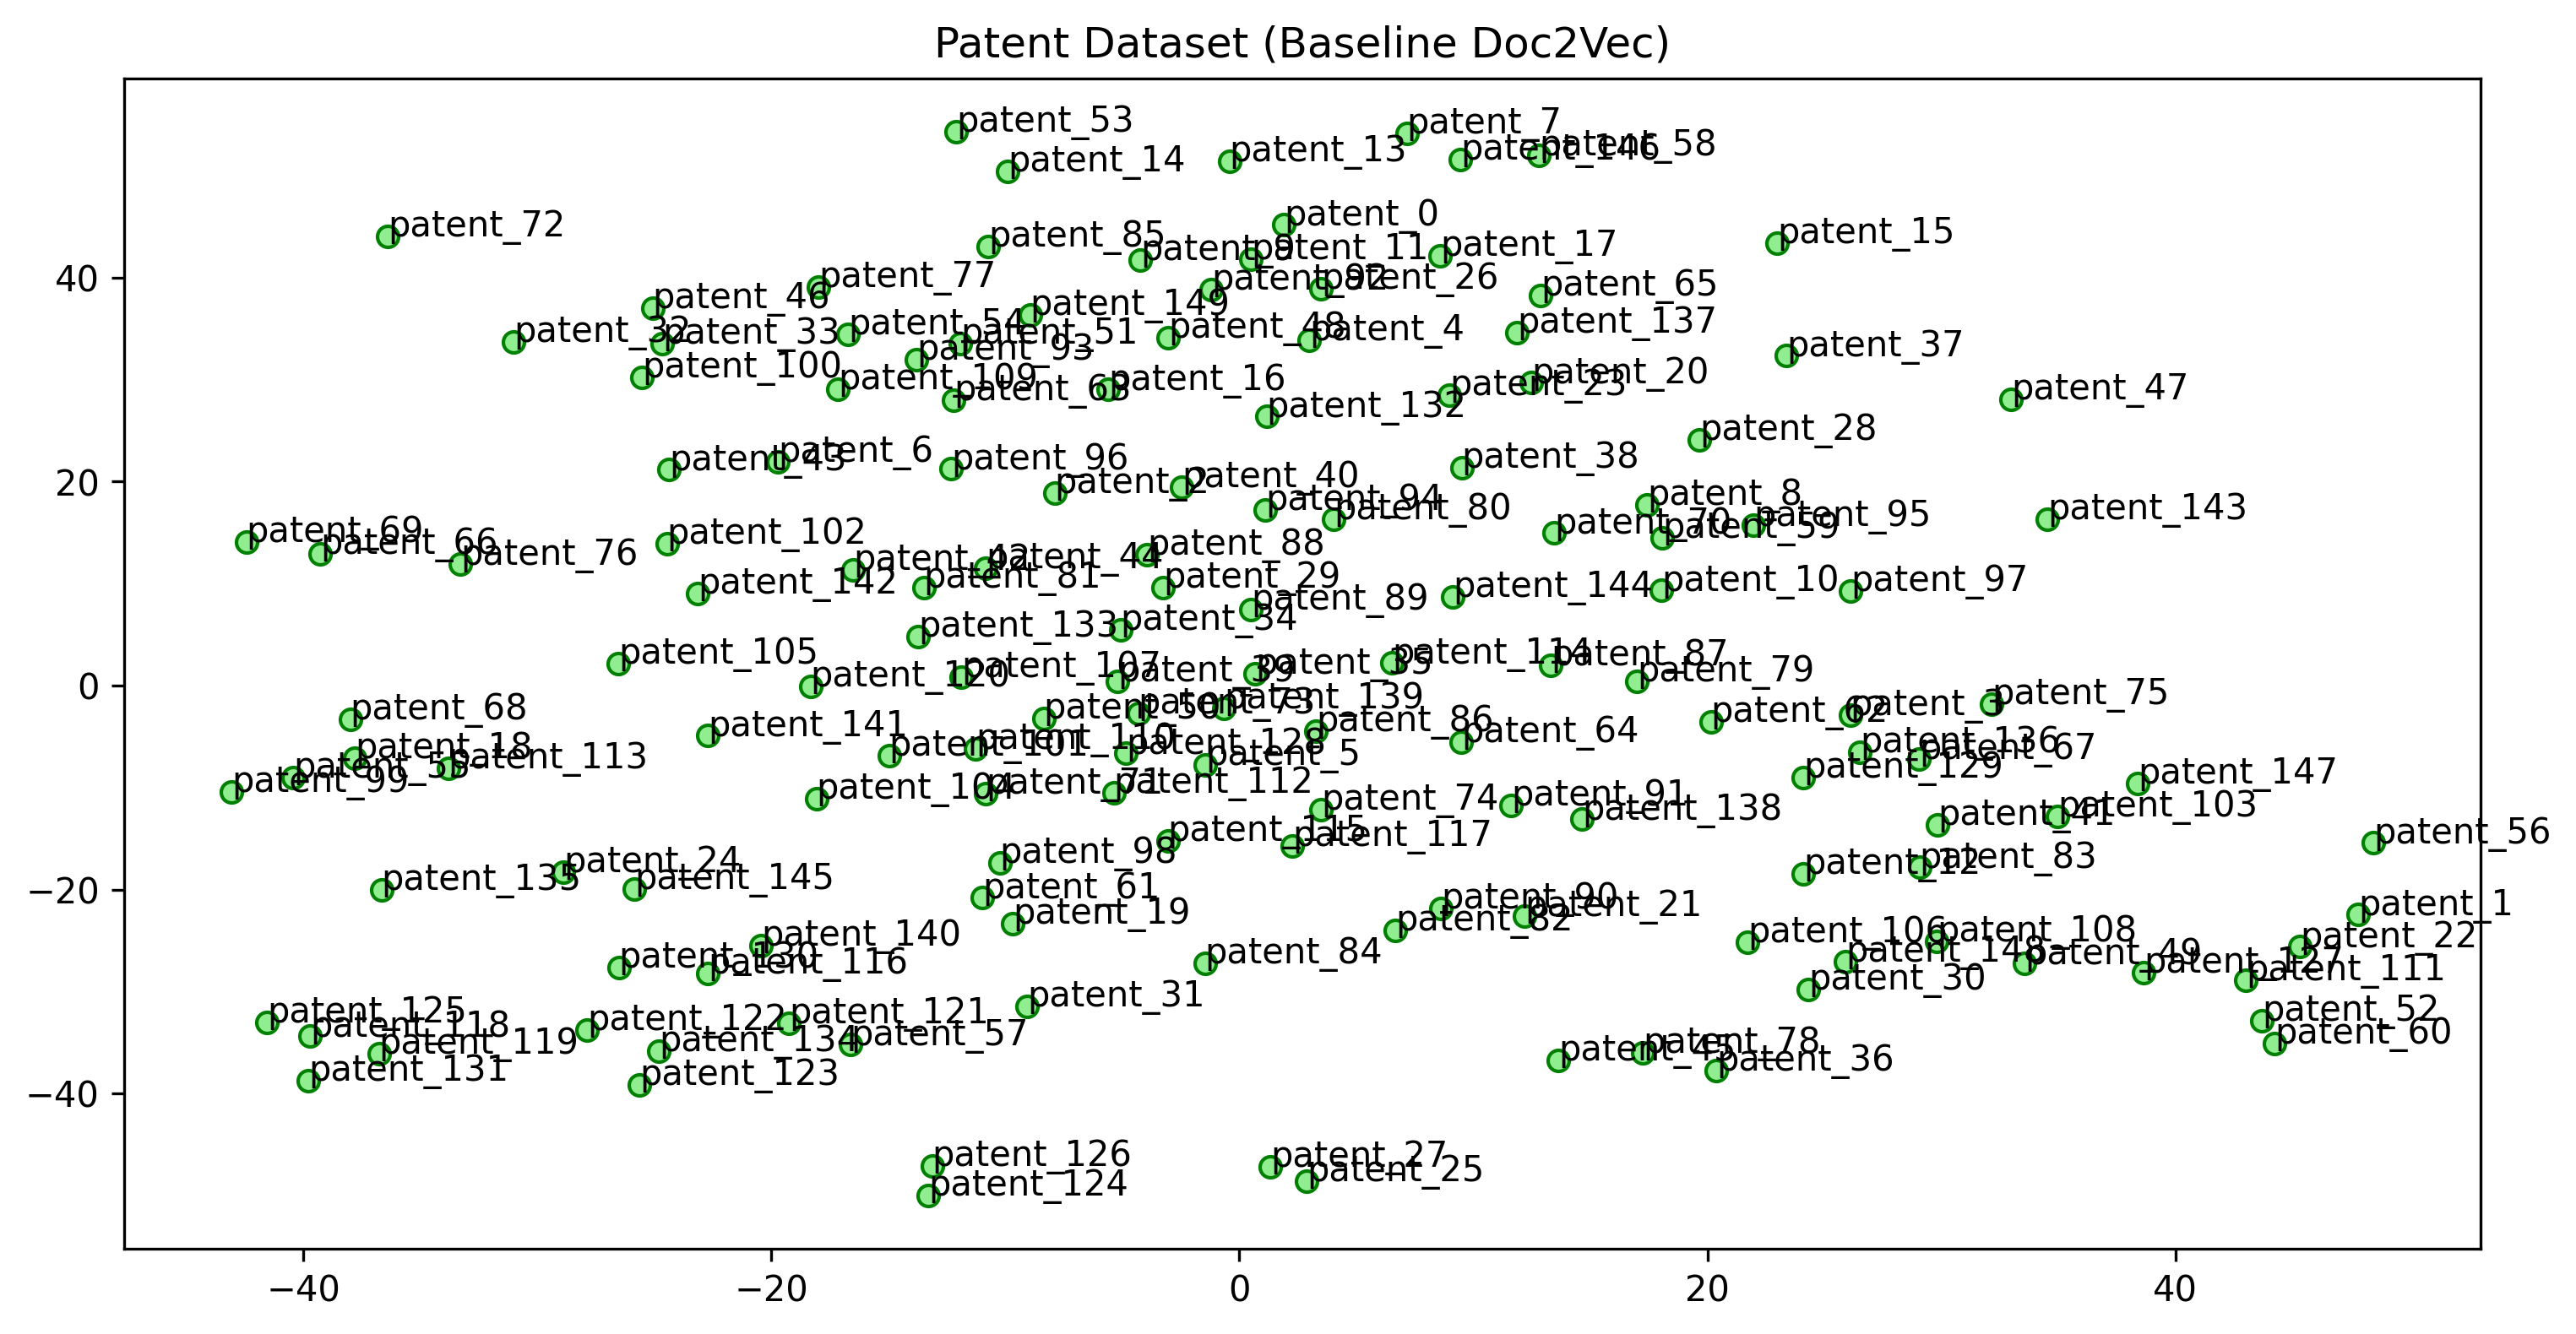

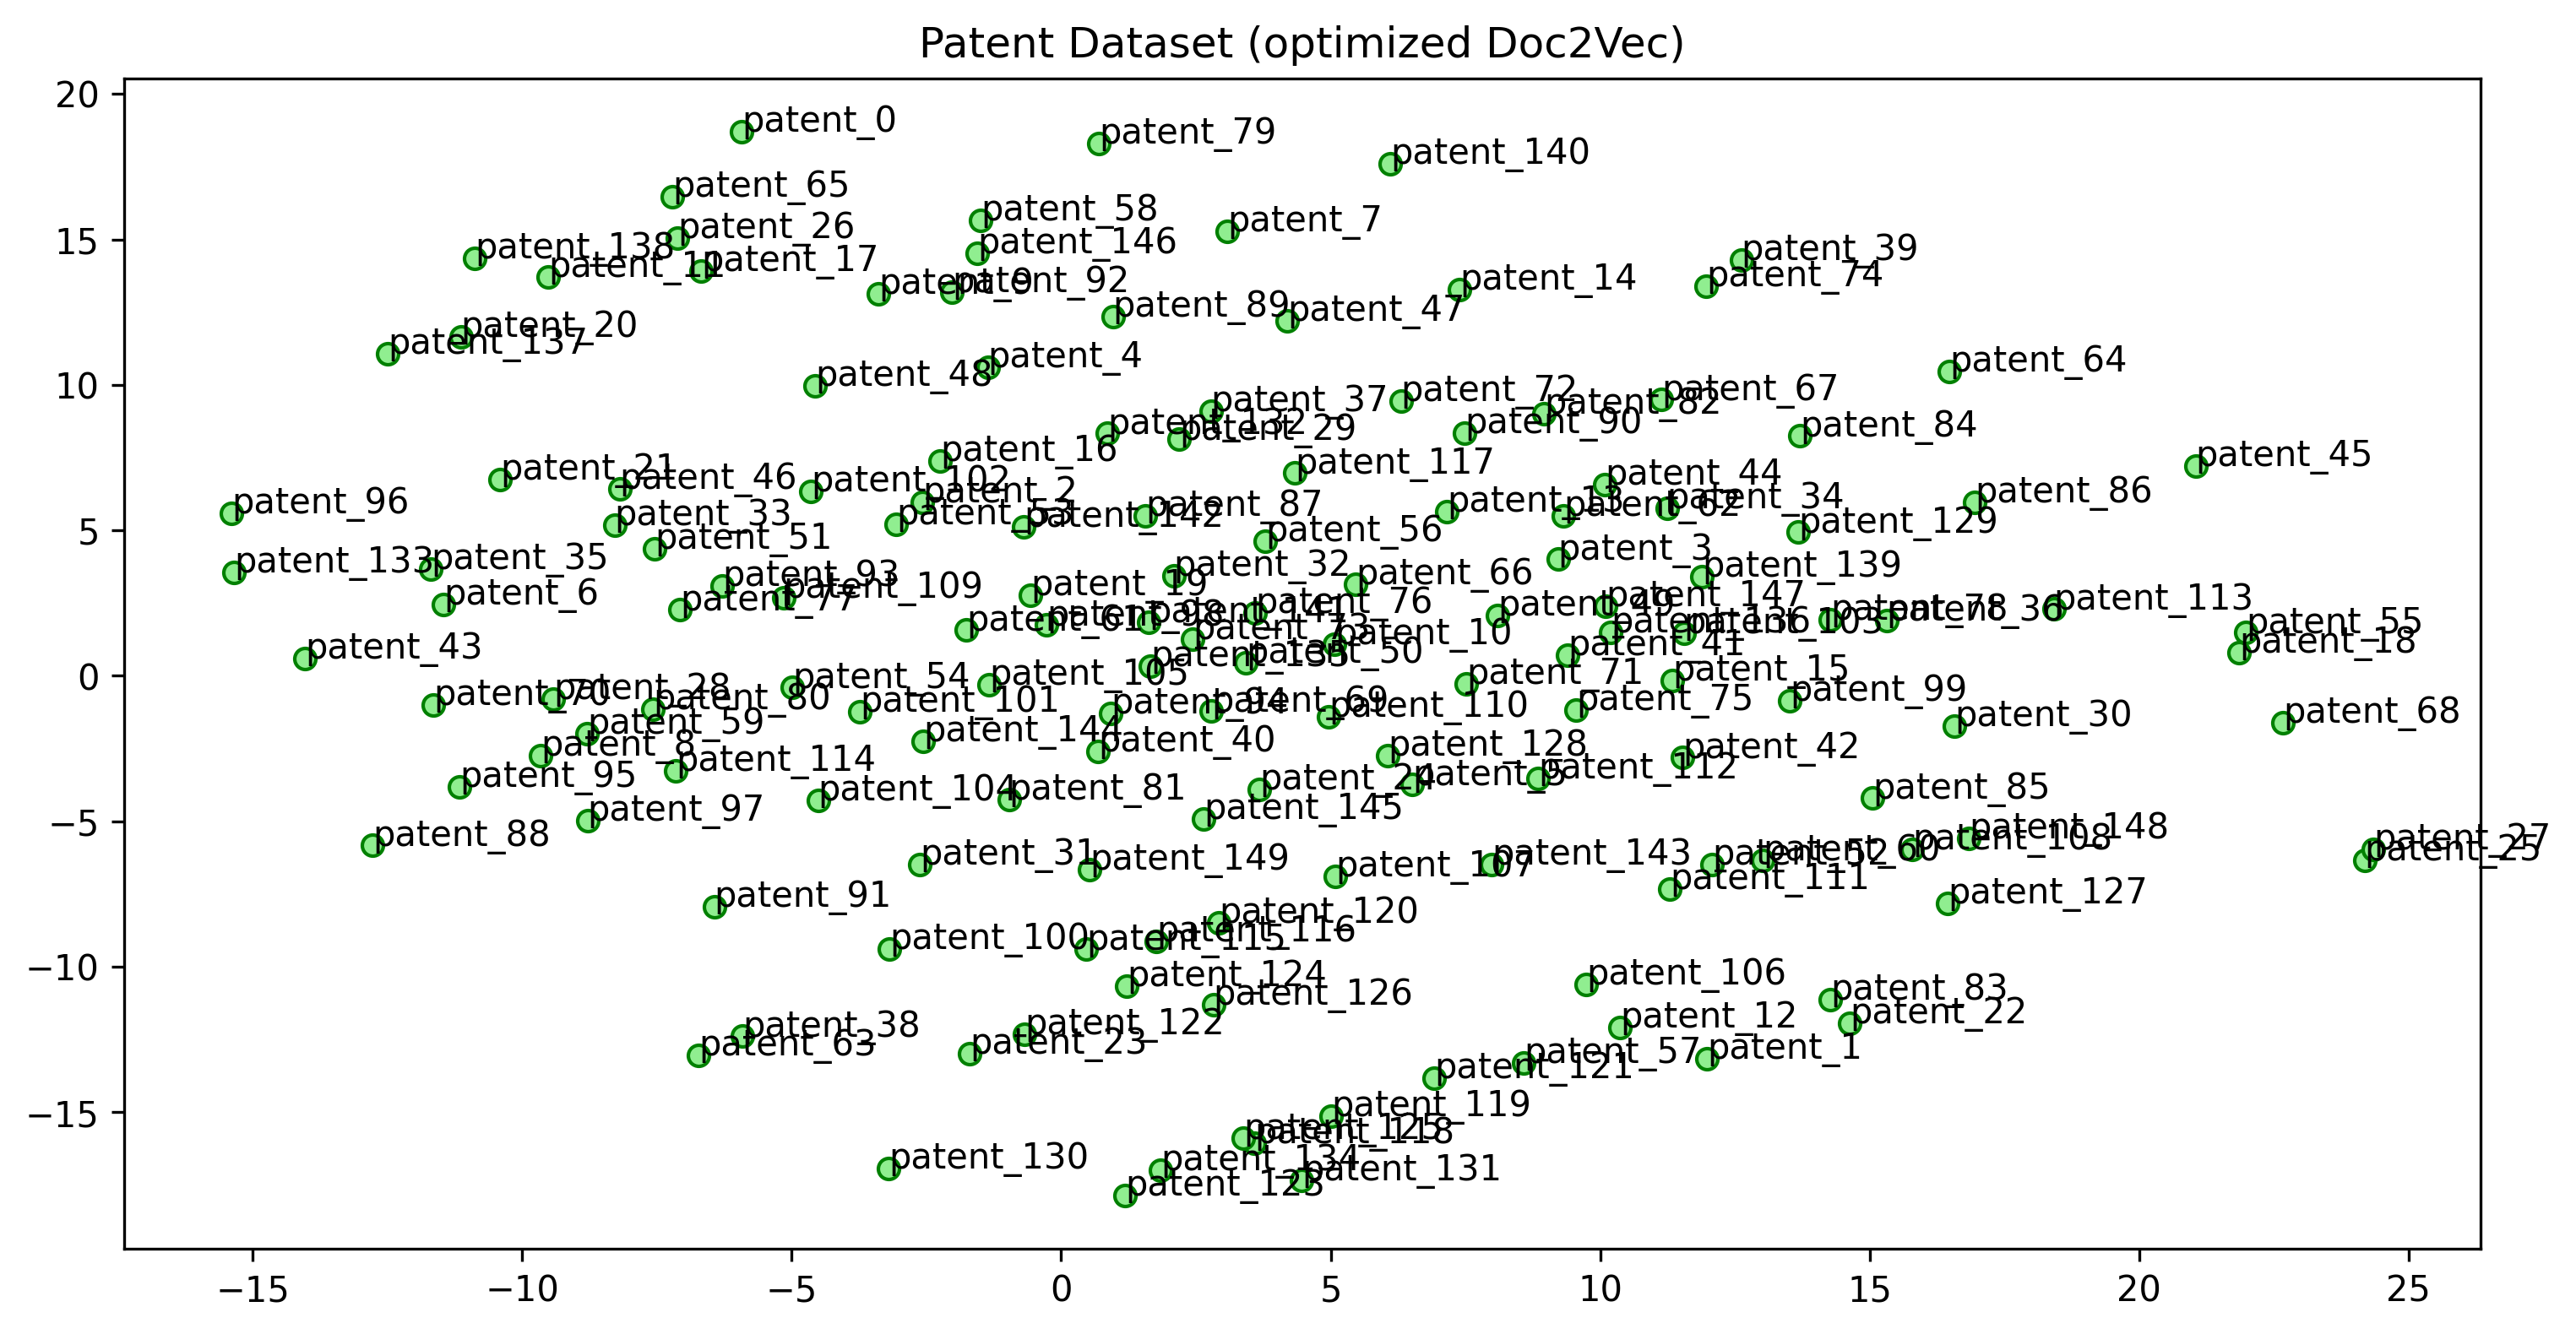

In [ ]:
# Visualizing embeddings
visualize_embeddings(doc2vec_patent_baseline, "Patent Dataset (Baseline Doc2Vec)")
visualize_embeddings(doc2vec_patent_optimized, "Patent Dataset (optimized Doc2Vec)")

**Key Findings from the Patent Dataset Visualization**

- Baseline Model:Forms some compact, distinct clusters, showing strong topic separation but potentially overfitting to specific terms.  
- Optimized Model: Displays fewer clusters and a more evenly distributed space, capturing broader relationships rather than enforcing rigid separations.  
- Comparison: The baseline model differentiates topics more strictly, while the optimized model generalizes better, making it more flexible for search and retrieval tasks.  

To further evaluate the embeddings, we recommend quantitative cluster validation using Silhouette Score (from Data Quality) or  applying K-Means clustering to compare compactness. Additionally, experimenting with larger feature sizes and conducting a nearest neighbor analysis could provide deeper insights into the quality of the learned representations.  




### **Thematic Overlap Analysis: Media vs. Patent Documents**  

#### **Objective**  
To explore thematic overlaps and differences between media articles and patents, we compute document-level similarity using Doc2Vec embeddings. By finding the most similar patent document for each media document, we identify shared topics, potential research gaps, and areas where innovation in patents is ahead of media discussions.

### **Methodology**  
- Extract embeddings from trained Doc2Vec models for both datasets.  
- Compute cosine similarity between each media document and all patent documents.  
- Identify the most similar patent document for each media document based on cosine similarity.  
- Analyze thematic connections between patents and media discussions.  


In [ ]:
# Extract document vectors for both datasets
media_vectors = np.array([doc2vec_media_optimized.dv[i] for i in range(len(df_media_tl))])
patent_vectors = np.array([doc2vec_patent_optimized.dv[i] for i in range(len(df_patent_tl))])

# Compute cosine similarity between media and patent document embeddings
similarities = cosine_similarity(media_vectors, patent_vectors)

# Find the most similar patent document for each media document
most_similar_patents = np.argmax(similarities, axis=1)

# Display top matches
print("\n Top 5 Media-Patent Matches")
for i in range(5):
    media_idx = i
    patent_idx = most_similar_patents[i]

    print(f"\nMedia Document {media_idx} → Closest Patent {patent_idx}")
    print(f"Media: {' '.join(df_media.iloc[media_idx]['tokens'][:30])}...")
    print(f"Patent: {' '.join(df_patent.iloc[patent_idx]['tokens'][:30])}...")


 **Top 5 Media-Patent Matches**

**Media Document 0 → Closest Patent 14127**
**Media**: chinese automotive startup xpeng has shown one of the most dramatic auto production rampups in history and the good news is it only produces 100 st electric vehicles evs at...
**Patent**: the invention discloses a flow pushing device which drives a flow pusher to work through a wind power driving device or a solar power driving device pushes river water flow...

**Media Document 1 → Closest Patent 6139**
**Media**: sinopec has laid plans to build the largest green hydrogen production facility in the world but interest in fossilsourced hydrogen continues apace skepticism abounds over the green hydrogen field and...
**Patent**: the present invention refers to a method and device for the production of hydrogen through the dissociation of the water molecule through thermochemical reactions using a small amount of active...

**Media Document 2 → Closest Patent 5693**
**Media**: huaneng power internation

**Key Findings from Media-Patent Similarity Analysis**  

- Renewable Energy Innovation Trends Align: Both media and patents focus on solar power, wind energy, and hydrogen technologies, showing strong thematic connections.  
- Divergence in Solar Energy Coverage: Media primarily reports on photovoltaic (PV) expansionand policy-driven solar investments, while patents explore a broader range of solar innovations, including solar-powered heating devices and hybrid solar-hydro systems.  
- Underreported Technical Innovations: Certain patents on material science advancements (e.g., hydrogen membranes) lack corresponding media coverage, suggesting potential breakthroughs that have not yet gained public attention.  

Future Opportunities: Further analysis could track how quickly patent innovations make it into mainstream media discussions, helping identify early-stage technologies with high market potential.  


## Transfer Learning with Advanced Open-Source Models

In this section, we fine-tune a RoBERTa-base model on our text data using transfer learning. [RoBerta](https://huggingface.co/FacebookAI/roberta-base) is a transformer model pre-trained with Masked Language Modeling (MLM), where 15% of words are masked and the model learns to predict them, enabling it to understand deep semantic context.

We compare the performance of a fine-tuned and pre-trained RoBERTa-base model using topic classification.

Before and after fine-tuning on cleantech-specific text, we evaluate the model using intrinsic measures:
- Word similarity
- Clustering quality

In [ ]:
!nvidia-smi

Fri Mar 28 19:22:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
df_patent_tl['abstract'].nunique()
df_media_tl['content'].nunique()
len(df_media_tl)

20111

In [ ]:
# Add labels
df_patent_tl['label'] = 0
df_media_tl['label'] = 1

df_all = pd.concat([
    df_patent_tl[['abstract', 'label']].rename(columns={'abstract': 'text'}),
    df_media_tl[['content', 'label']].rename(columns={'content': 'text'})
])

In [ ]:
# Split into train+val and test
df_temp, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all['label'], random_state=42)

# Split train+val into train and validation
df_train, df_val = train_test_split(df_temp, test_size=0.1, stratify=df_temp['label'], random_state=42)


In [ ]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
model_name = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

# Remove columns not needed
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/35235 [00:00<?, ? examples/s]

Map:   0%|          | 0/3915 [00:00<?, ? examples/s]

Map:   0%|          | 0/9788 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-105-582cf9bc7503>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=6609, training_loss=0.0015147103642531045, metrics={'train_runtime': 1139.5168, 'train_samples_per_second': 92.763, 'train_steps_per_second': 5.8, 'total_flos': 1.39060770534144e+16, 'train_loss': 0.0015147103642531045, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 2.930108394139097e-06, 'eval_accuracy': 1.0, 'eval_runtime': 14.6421, 'eval_samples_per_second': 267.38, 'eval_steps_per_second': 33.465, 'epoch': 3.0}


The model achieved a training and validation accuracy of 100% after just one epoch, with training and validation losses dropping to zero by the second epoch. While this might suggest excellent performance, such results are highly suspicious and likely indicative of overfitting or data leakage.

In [ ]:
 print(df_test['label'].value_counts())

label
0    5766
1    4022
Name: count, dtype: int64


The confusion matrix confirms that both labels are present in the predictions, meaning the model is not simply predicting a single label for all samples.

In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification report
print(classification_report(labels, preds, target_names=["patent", "media"]))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(labels, preds))


              precision    recall  f1-score   support

      patent       1.00      1.00      1.00      5766
       media       1.00      1.00      1.00      4022

    accuracy                           1.00      9788
   macro avg       1.00      1.00      1.00      9788
weighted avg       1.00      1.00      1.00      9788

Confusion Matrix:
[[5766    0]
 [   0 4022]]


**Perfect accuracy – suspicious.**

It was verified that no test samples were mistakenly included in the training or validation sets. Upon closer inspection (Stage 1), it's clear that the texts differ significantly between classes – for example, in terms of length, complexity, and content.

To further investigate potential data leakage (e.g., if a column contains the word "patent"), we will now evaluate how an unfine-tuned model classifies the labels.

In [ ]:
# Only the pre-trained RoBERTa with random classification head
model_untrained = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Dummy Trainer nur für Evaluation
trainer_untrained = Trainer(
    model=model_untrained
)

# Predictions
raw_pred = trainer_untrained.predict(test_dataset)


preds = np.argmax(raw_pred.predictions, axis=1)
labels = raw_pred.label_ids

print(classification_report(labels, preds, target_names=["Patent", "Media"]))


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


              precision    recall  f1-score   support

      Patent       0.60      1.00      0.75      5766
       Media       0.94      0.06      0.12      4022

    accuracy                           0.61      9788
   macro avg       0.77      0.53      0.44      9788
weighted avg       0.74      0.61      0.49      9788



In [ ]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(labels, preds))

Confusion Matrix:
[[5750   16]
 [3763  259]]


**Unfine-tuned model performance.**

The pre-trained RoBERTa model without fine-tuning shows a clear bias towards the "Patent" class, predicting it almost exclusively. While the recall for "Patent" is 1.00, the precision is only 0.60, and the "Media" class is heavily underrepresented (recall = 0.06). Overall accuracy is 61%, indicating the model is not guessing randomly, but still lacks understanding of the actual classification task. This supports the assumption that our fine-tuned models strong performance is not due to label leakage, but rather effective learning from class-distinct features.

**Intrinsic Evaluation of RoBERTa Representations**

To assess how well the fine-tuned RoBERTa model captures semantic differences between patent and media texts, we extracted sentence embeddings using the [CLS] token representation from both the pre-trained (untrained) and fine-tuned models. During training, this token is designed to capture the overall meaning of the entire input sequence.

We then evaluated the clustering quality using the Silhouette Score, which measures how well embeddings form separable clusters.



In [ ]:
def get_cls_embeddings(model, texts, batch_size=32):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(embeddings)

In [ ]:
# sample 2000
sample_df = df_test.sample(n=2000, random_state=42)
texts = sample_df['text'].tolist()
labels = sample_df['label'].tolist()

# Get encoder-only models
encoder_untrained = RobertaModel.from_pretrained("roberta-base")
encoder_finetuned = model.roberta  # from your fine-tuned model

# Get embeddings
emb_untrained = get_cls_embeddings(encoder_untrained, texts)
emb_finetuned = get_cls_embeddings(encoder_finetuned, texts)

In [ ]:
def evaluate_clustering(embeddings, labels):
    kmeans = KMeans(n_clusters=2, random_state=42)
    preds = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, preds)
    return score

score_untrained = evaluate_clustering(emb_untrained, labels)
score_finetuned = evaluate_clustering(emb_finetuned, labels)

print(f"Silhouette Score (Untrained): {score_untrained:.4f}")
print(f"Silhouette Score (Fine-tuned): {score_finetuned:.4f}")

Silhouette Score (Untrained): 0.2176
Silhouette Score (Fine-tuned): 0.9364


The fine-tuned model's embeddings form well-defined, compact clusters that align strongly with the true labels, indicating that the model has learned to internally differentiate between patent and media texts. This confirms the effectiveness of fine-tuning in creating task-specific semantic representations in the cleantech domain.

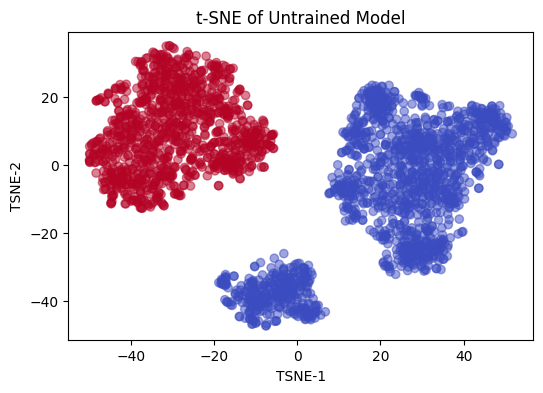

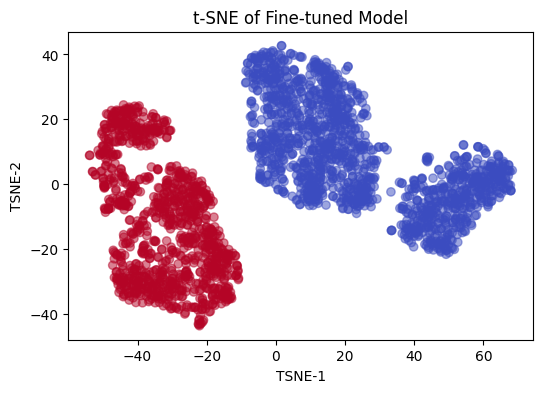

In [ ]:
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(6, 4), dpi=100)
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="coolwarm", alpha=0.5)
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.show()

plot_tsne(emb_untrained, labels, "t-SNE of Untrained Model")
plot_tsne(emb_finetuned, labels, "t-SNE of Fine-tuned Model")

**Key Findings**

Although both the untrained and fine-tuned RoBERTa models show visually separated clusters in the t-SNE plots, only the fine-tuned model forms tight and compact clusters that are semantically meaningful. The untrained model’s separation is likely due to superficial patterns or random initialization, as indicated by its low Silhouette Score (0.2176). In contrast, the fine-tuned model achieves a high Silhouette Score (0.9364), confirming that it has learned task-specific representations that clearly distinguish between "media" and "patent" texts.